In [3]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import boxcox
import statsmodels.stats as sm_stats
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb

data, meta = arff.loadarff('MagicTelescope.arff')

df = pd.DataFrame(data)

# --- Normalize column names: strip whitespace, remove special chars, make lowercase ---
df.columns = df.columns.astype(str).str.strip() \
                       .str.replace(r'[^0-9A-Za-z_]', '', regex=True)

df['class'] = df['class'].str.decode('utf-8')


# strip whitespace from string columns
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    df[col] = df[col].str.strip()
class_mapping = {'g': 1, 'h': 0}
df['class'] = df['class'].map(class_mapping)
df.drop('ID', axis=1, inplace=True)


In [366]:
df.shape

(19020, 11)

In [367]:
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

In [368]:
df.describe()

fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      -4.331745     10.545545      0.249726     27.645707    193.818026   
std       59.206062     51.000118     20.827439     26.103621     74.731787   
min     -457.916100   -331.780000   -205.894700      0.000000      1.282600   
25%      -20.586550    -12.842775    -10.849375      5.547925    142.492250   
50%        4.013050     15.314100      0.666200     17.679500    191.851450   
75%       24.063700     35.837800     10.946425     45.883550    240.563825   
max      575.240700    238.321000    179.851000     90.000000    495.561000   

              class  
count  19020.000000  
mean       0.648370  
std        0.477492  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [370]:
df.nunique()

fLength     18643
fWidth      18200
fSize        7228
fConc        6410
fConc1       4421
fAsym       18704
fM3Long     18693
fM3Trans    18390
fAlpha      17981
fDist       18437
class           2
dtype: int64

In [371]:
print(df.duplicated().sum())

115


In [372]:
print(df.isna().sum())

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


In [39]:
data_all = df[col].dropna()
data_g = df[df['class'] == 0][col].dropna()  # 1 for 'g'
data_h = df[df['class'] == 1][col].dropna()  # 0 for 'h'

In [40]:
numeric_df = df.select_dtypes(include=[np.number])
cols = numeric_df.columns

correlations = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1, col2 = cols[i], cols[j]
        corr_value = np.corrcoef(df[col1], df[col2])[0, 1]
        correlations.append((col1, col2, corr_value))

corr_df = pd.DataFrame(correlations, columns=["Feature 1", "Feature 2", "Correlation"])

corr_df = corr_df.sort_values(by="Correlation", ascending=False)

print("Top 20 najsilnejších korelácií:")
print(corr_df.head(10))
print(corr_df.tail(10))

Top 20 najsilnejších korelácií:
   Feature 1 Feature 2  Correlation
38     fConc    fConc1     0.976412
11   fLength    fWidth     0.770512
21    fWidth     fSize     0.717517
12   fLength     fSize     0.702454
36     fSize     fDist     0.437041
19   fLength     fDist     0.418466
8         ID    fAlpha     0.385102
28    fWidth     fDist     0.336816
51     fAsym   fM3Long     0.274045
0         ID   fLength     0.257243
   Feature 1 Feature 2  Correlation
43     fConc     fDist    -0.328332
15   fLength     fAsym    -0.368556
64    fAlpha     class    -0.460979
23    fWidth    fConc1    -0.581141
14   fLength    fConc1    -0.598145
22    fWidth     fConc    -0.609779
13   fLength     fConc    -0.630999
31     fSize    fConc1    -0.808835
10        ID     class    -0.827018
30     fSize     fConc    -0.850850


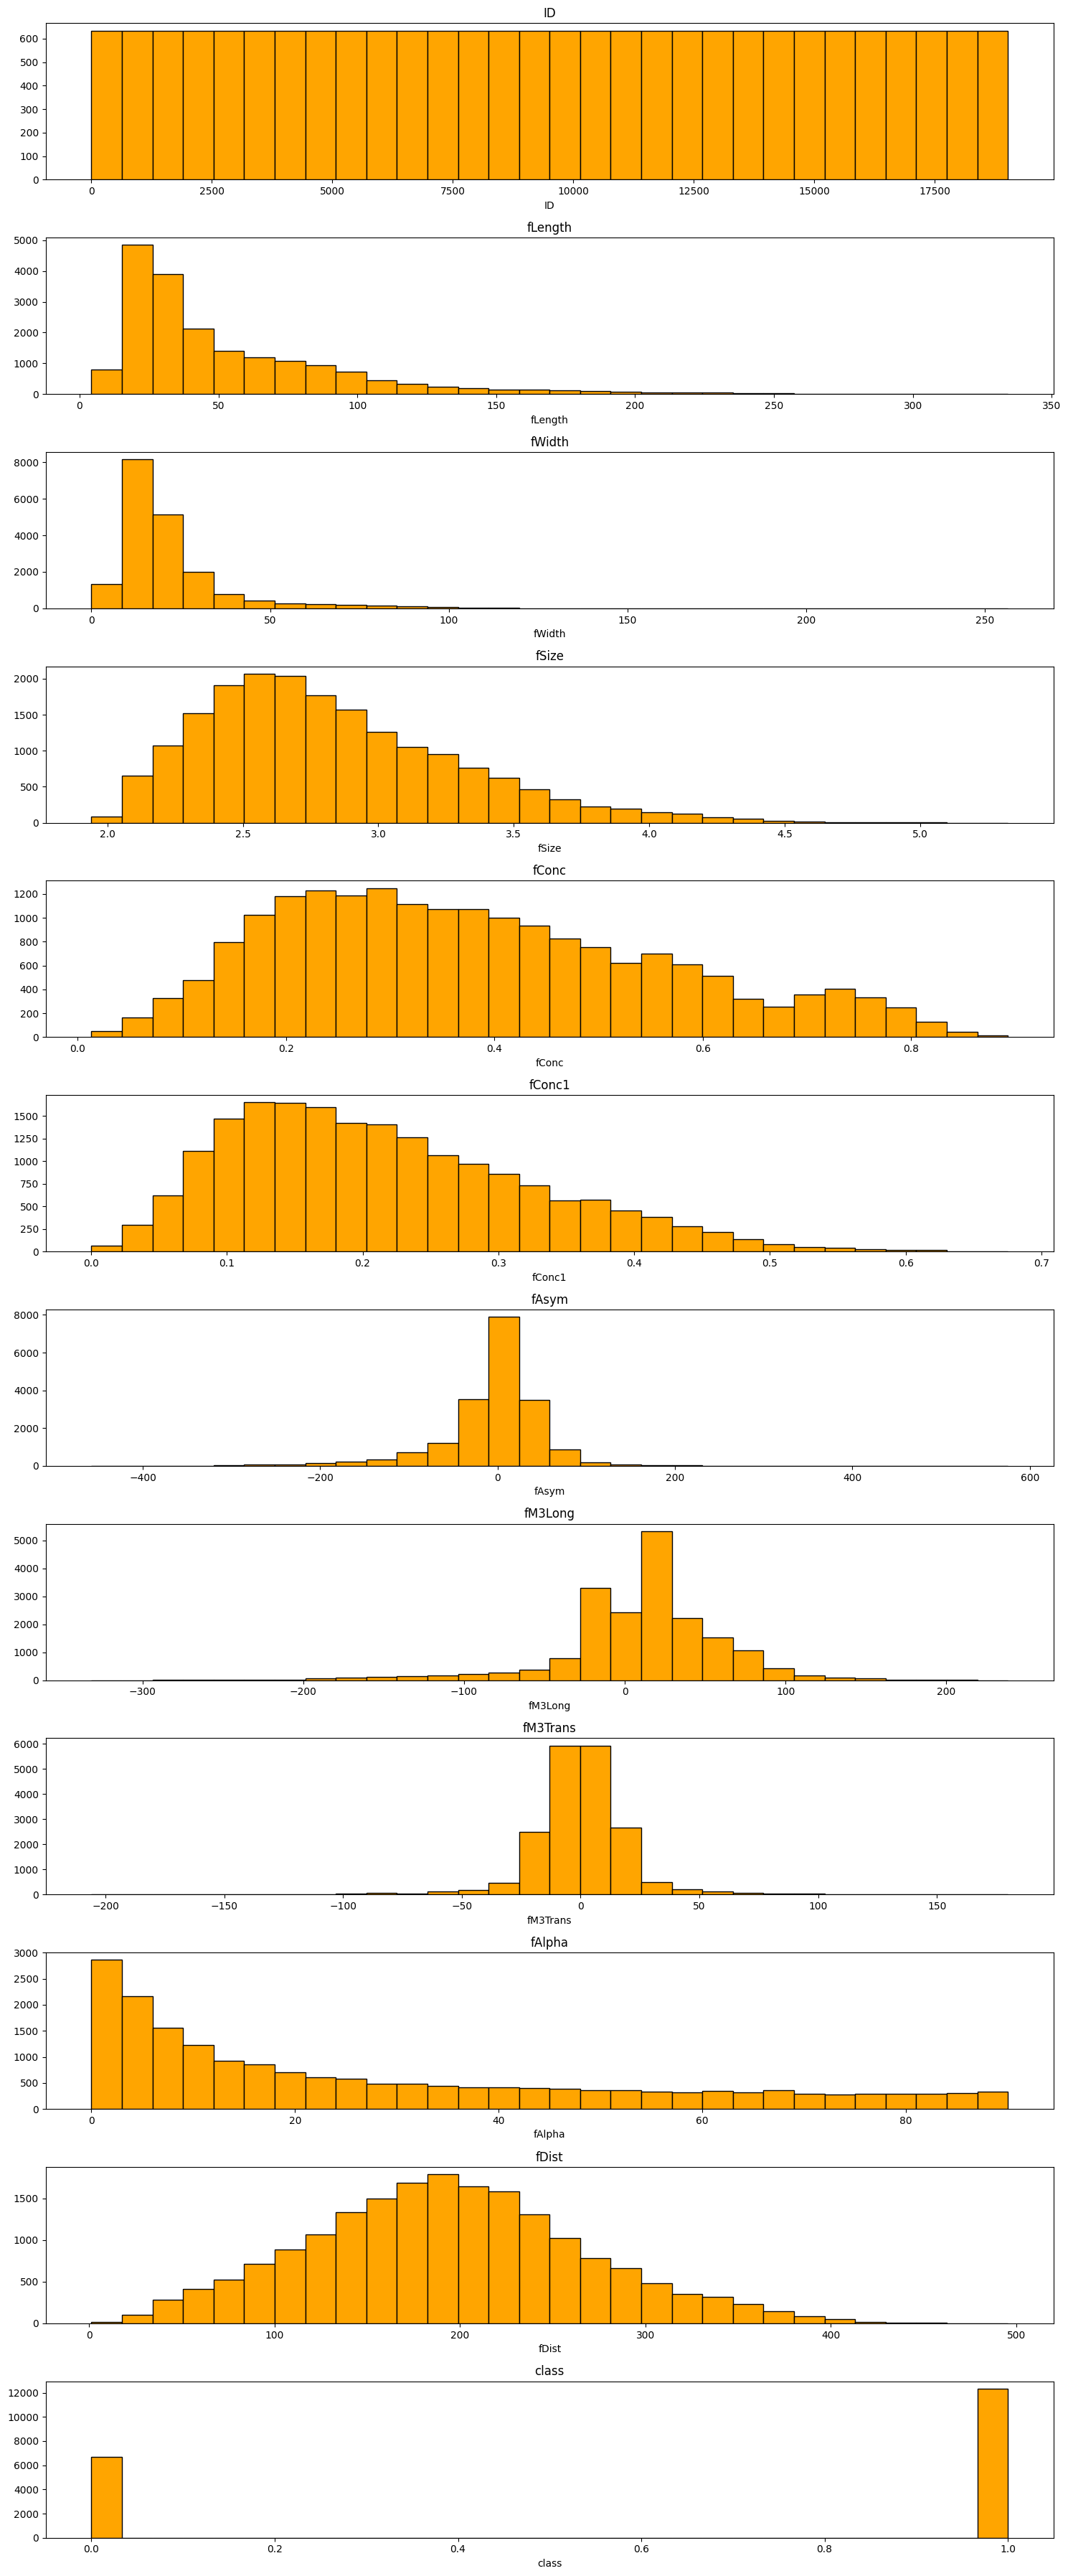

In [41]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.hist(df[col].dropna(), bins=30, color = "orange", edgecolor='black')
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

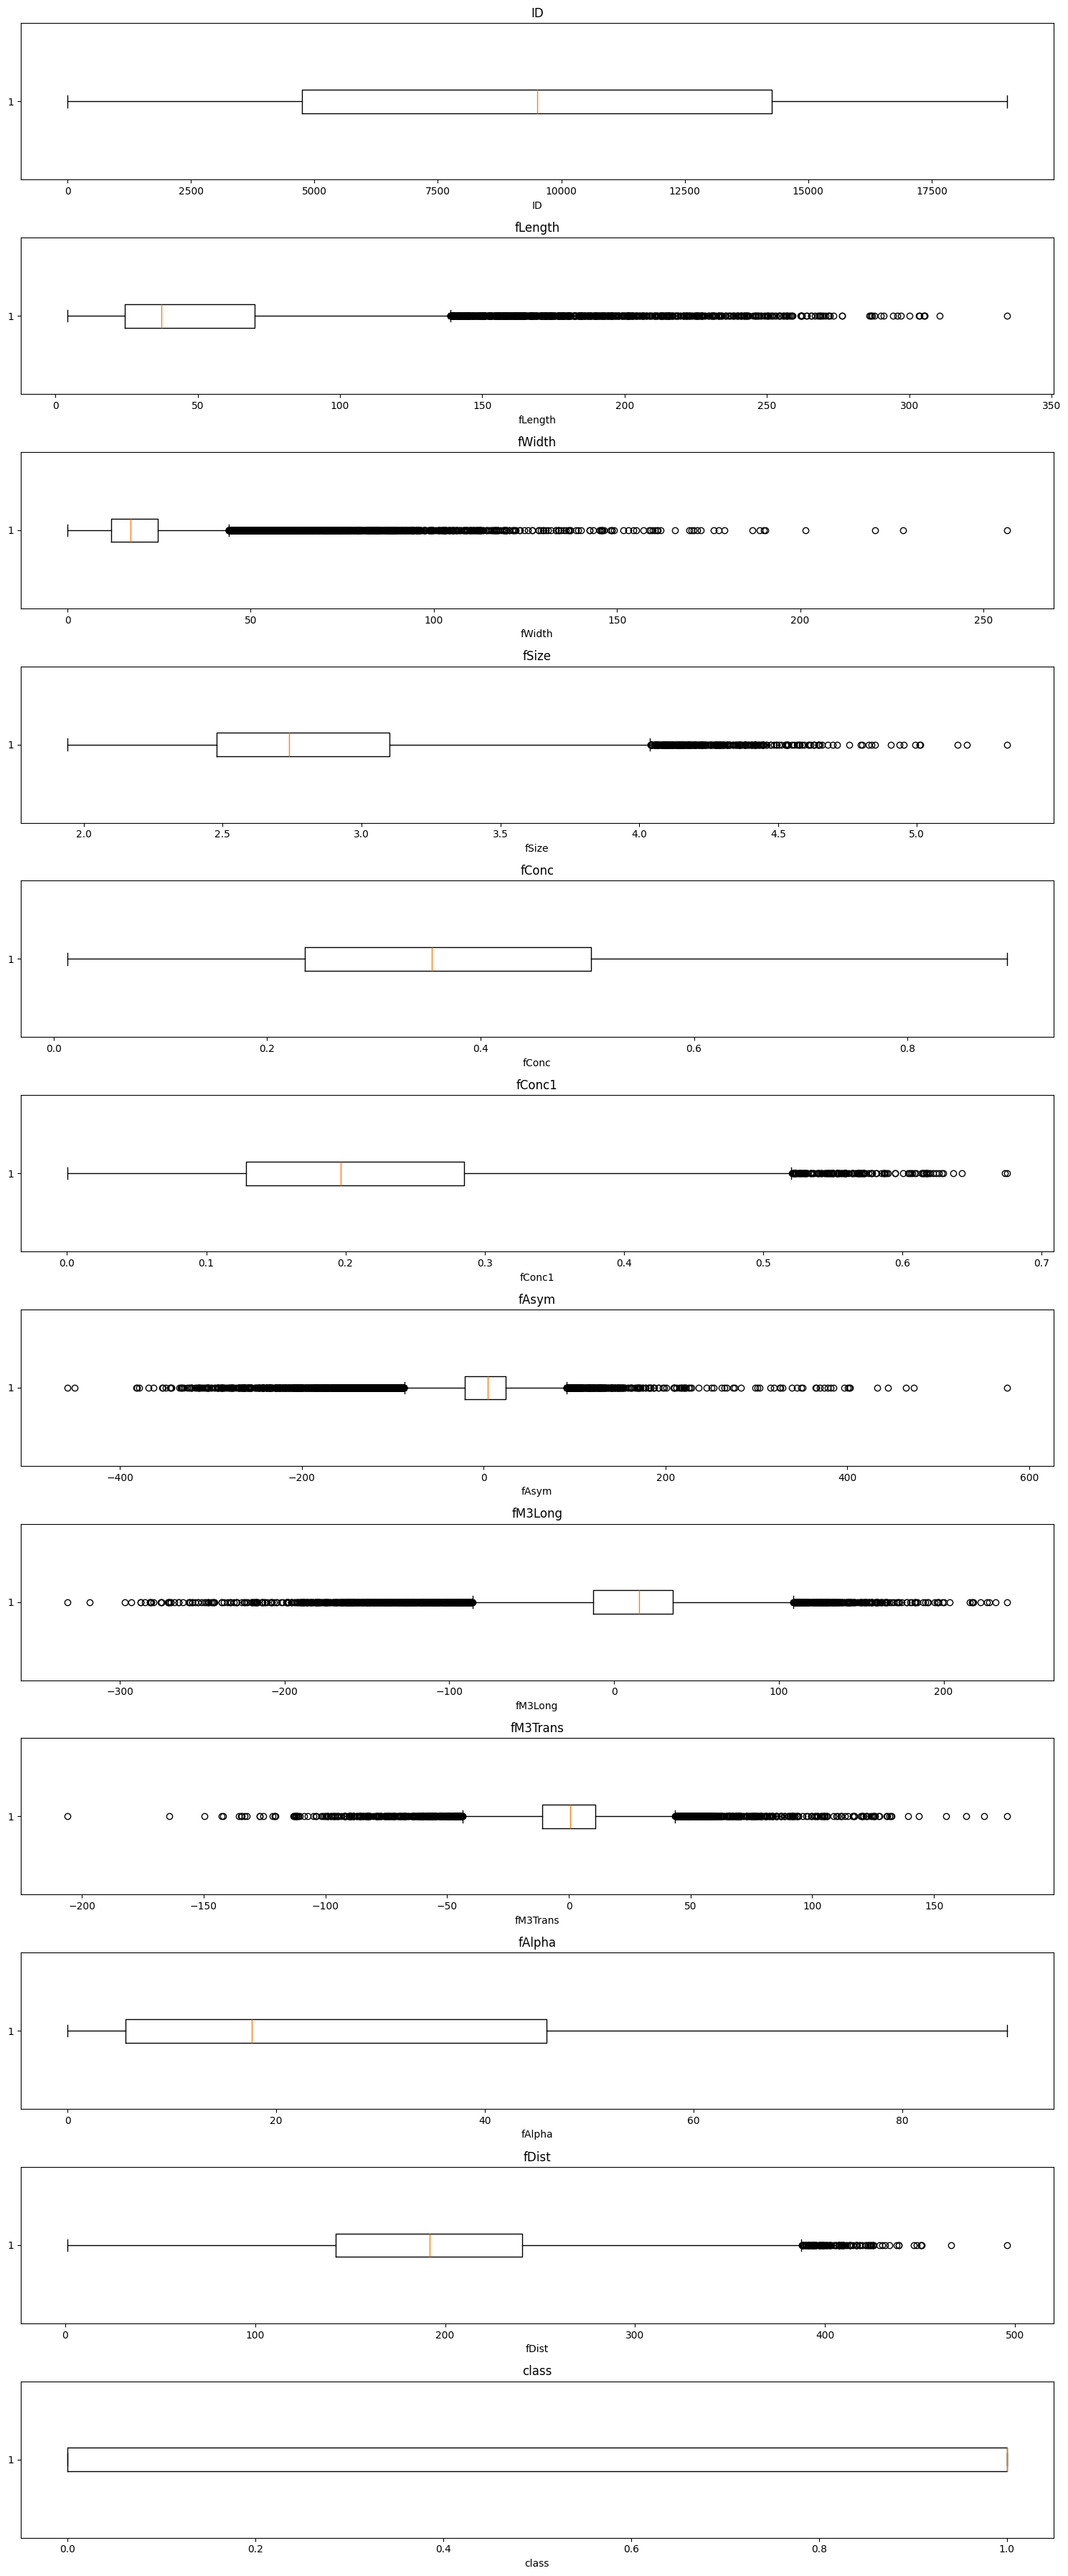

In [42]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [43]:
numeric_df = df.select_dtypes(include=[np.number])

for col in numeric_df.columns:
    stat, p = shapiro(df[col])
    print(p)

2.268443853164685e-59
8.133404060550683e-93
1.5423236511023563e-103
1.0950393740021794e-60
1.0260738464095494e-52
3.0703986576980104e-56
4.133179728229826e-84
1.4561558074025387e-72
1.0034033956235664e-78
6.257989223858619e-82
3.562749318318082e-25
1.0304298450095123e-108


C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19020.
  res = hypotest_fun_out(*samples, **kwds)


In [44]:
outliers_count = {}

for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    count = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)][col].count()
    outliers_count[col] = count

outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Column', 'Outliers_Count'])
outliers_df = outliers_df.sort_values(by='Outliers_Count', ascending=False)

print(outliers_df)

      Column  Outliers_Count
6      fAsym            1781
2     fWidth            1546
7    fM3Long            1218
1    fLength             971
8   fM3Trans             850
3      fSize             367
5     fConc1             150
10     fDist             128
0         ID               0
4      fConc               0
9     fAlpha               0
11     class               0


In [45]:
# Apply Box-Cox transformation to columns with high outlier counts to reduce skewness and outliers
# Box-Cox requires positive values; shift if necessary

columns_to_transform = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

for col in columns_to_transform:
    if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
        if (df[col] <= 0).any():
            shift = 1 - df[col].min()  # Shift to make all positive
            df[col] = df[col] + shift
        df[col], _ = boxcox(df[col])
        print(f"Box-Cox applied to {col}")

# Note: 'ID', 'fConc', 'fAlpha', 'class' have no outliers or are not numeric/transformable

Box-Cox applied to fAsym
Box-Cox applied to fWidth
Box-Cox applied to fM3Long
Box-Cox applied to fLength
Box-Cox applied to fM3Trans
Box-Cox applied to fConc1
Box-Cox applied to fDist
Box-Cox applied to fSize


In [46]:
# Alternative: Drop outliers instead of transforming
# Identify and drop rows where any of the outlier-prone columns have outliers (using IQR method)

# columns_with_outliers = ['fAsym', 'fWidth', 'fM3Long', 'fLength', 'fM3Trans', 'fConc1', 'fDist', 'fSize']

# # Create a mask to keep rows without outliers in any of these columns
# mask = pd.Series([True] * len(df), index=df.index)

# for col in columns_with_outliers:
#     if col in df.columns and df[col].dtype in [np.float64, np.int64, np.float32, np.int32]:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

# # Drop rows with outliers
# df = df[mask]

# print(f"Rows after dropping outliers: {len(df)}")
# print(f"Rows dropped: {len(mask) - len(df)}")

# Note: This removes rows where any of the specified columns have outliers. Adjust the list or logic if needed.
# After dropping, you can proceed with visualization or modeling.

In [47]:
print(df['class'].value_counts())

class
1    12332
0     6688
Name: count, dtype: int64


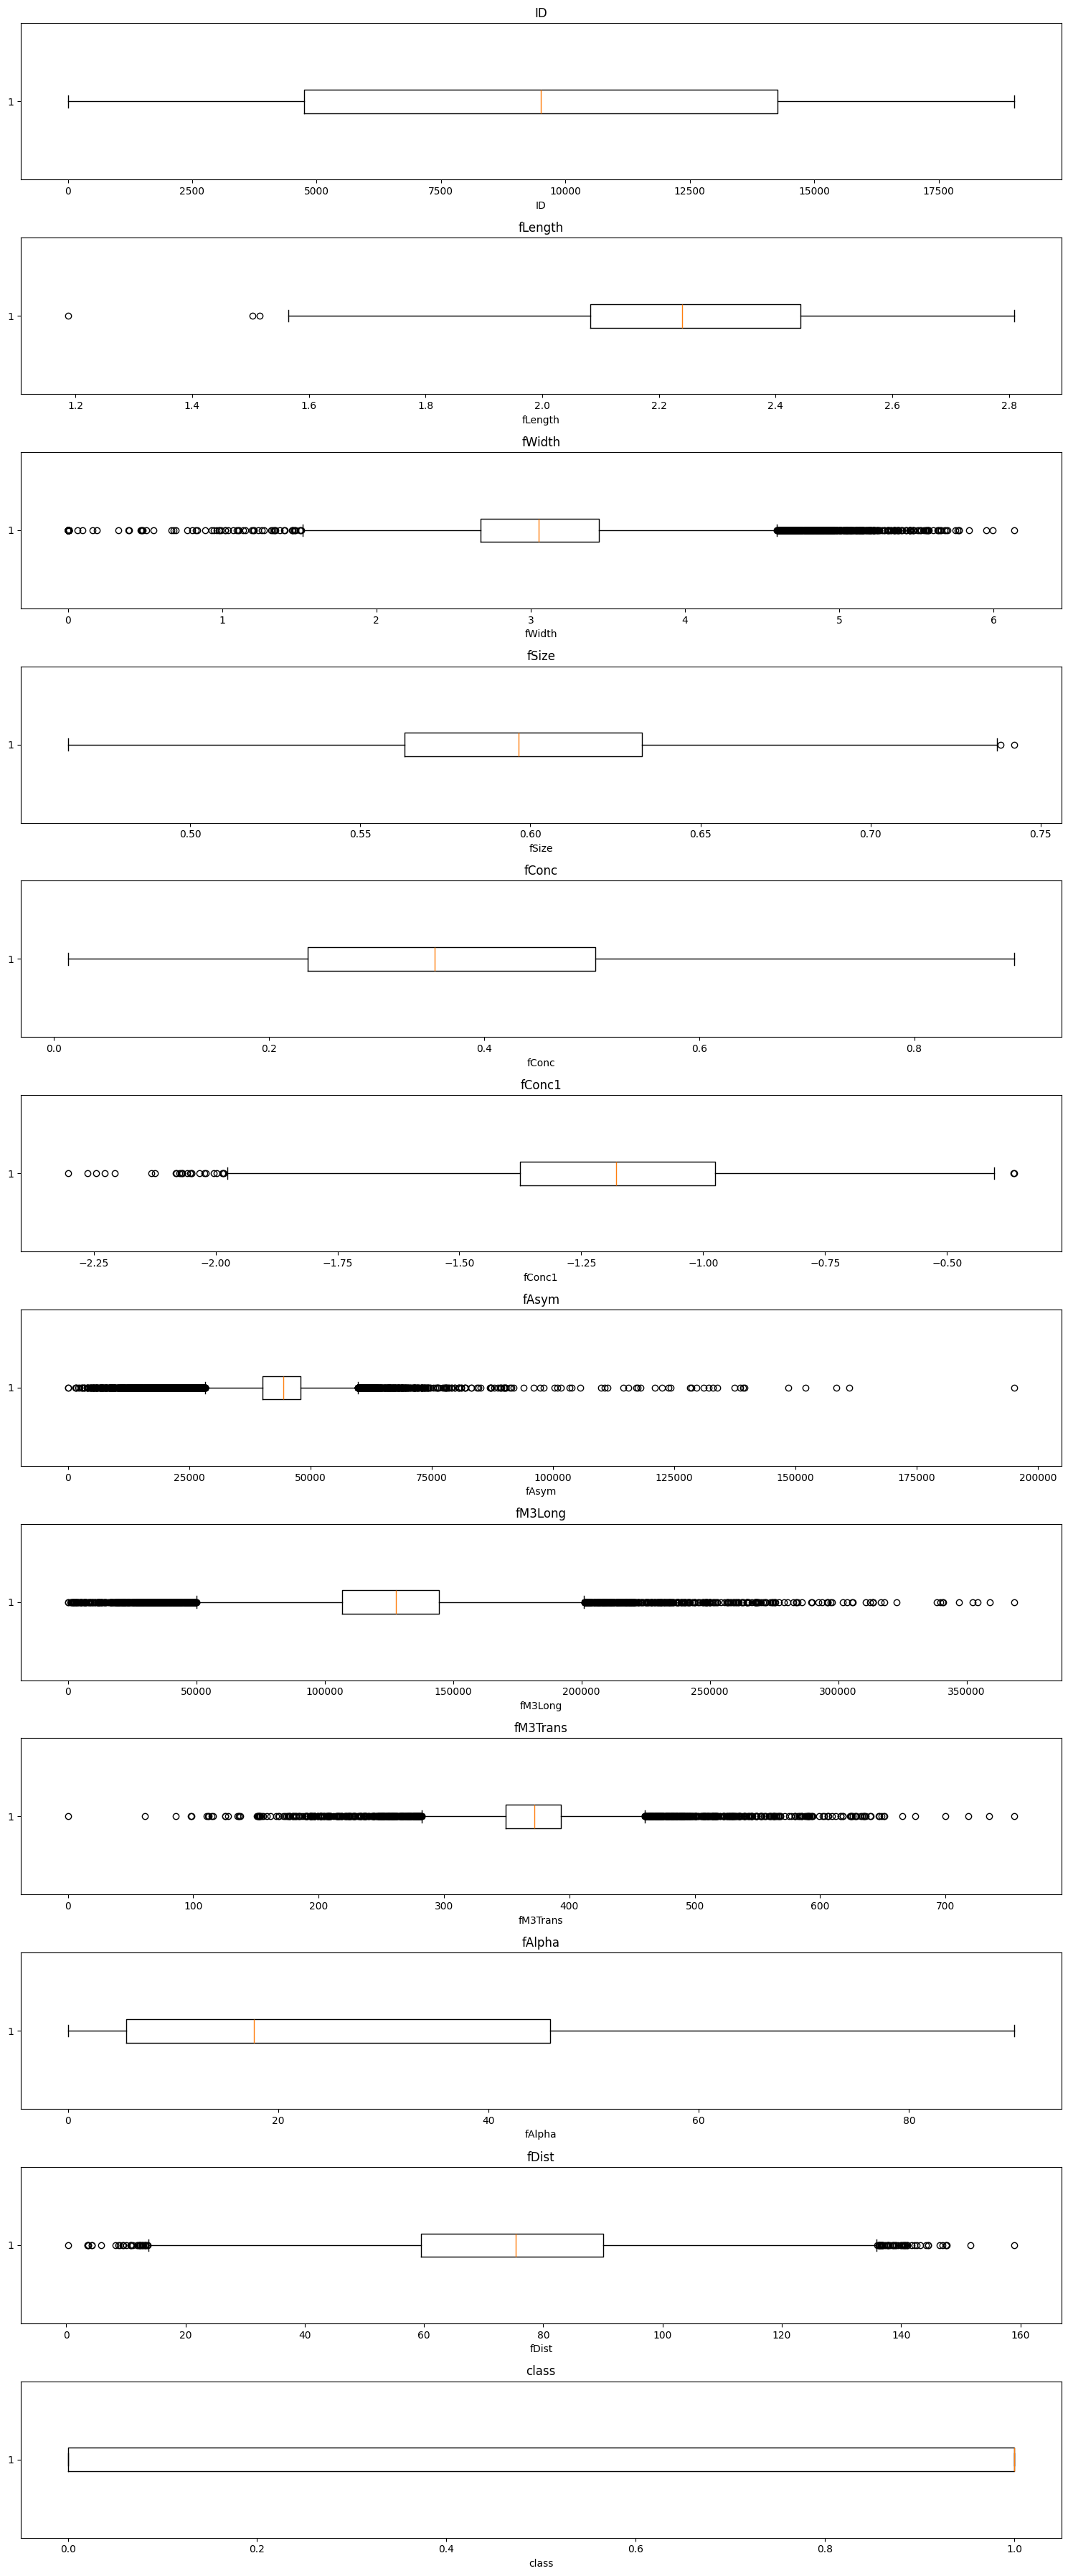

In [48]:
plt.figure(figsize=(15, len(cols) * 3))

for i, col in enumerate(cols, 1):
    plt.subplot(len(cols), 1, i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

For me it's a big problem to figure out what to do with outlires because it's our data and we can't just throw it away if we aren't sure that it has som problems. I have used boxcox to minimize influence and reduce amount of oulires in fSz.

## **Pairwise Correlation Matrix**

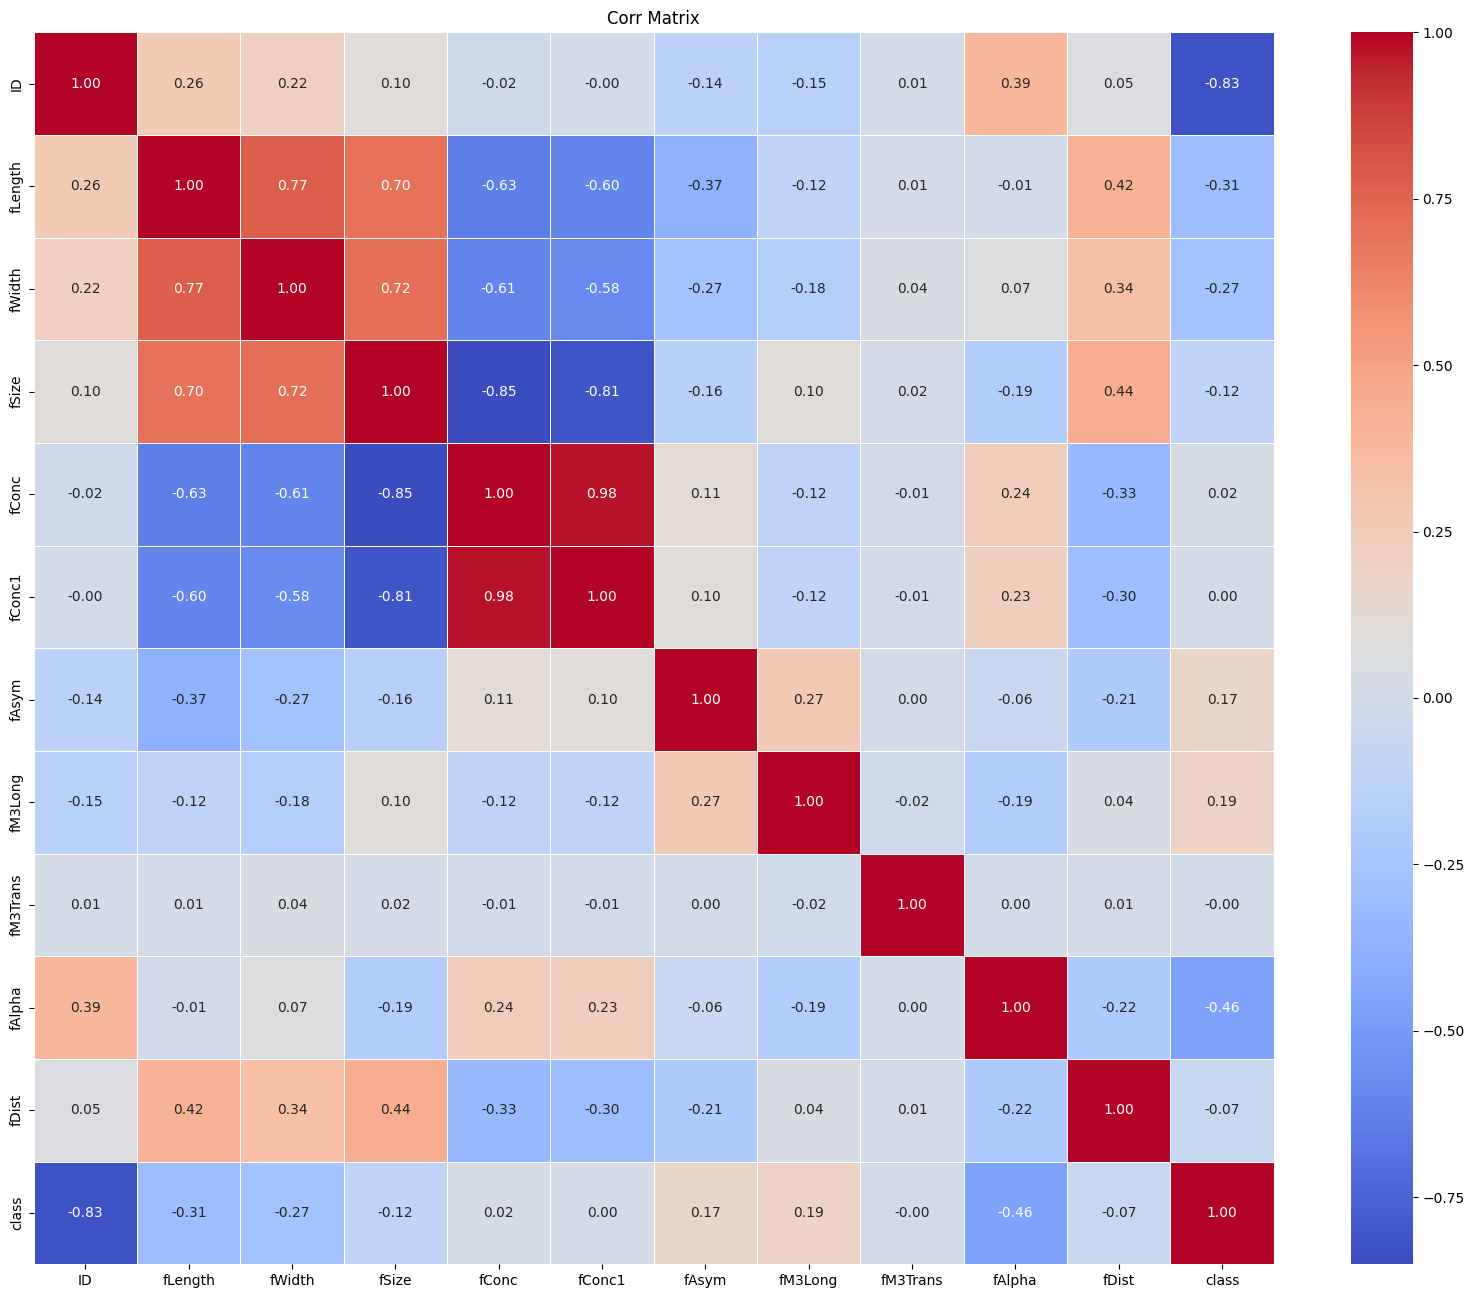

In [49]:
relationships_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(relationships_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Corr Matrix')
plt.show()

In [50]:
numeric_df = df.select_dtypes(include=[np.number])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [51]:
# Calculate correlations with 'class'
correlations_with_class = numeric_df.corr()['class'].abs().sort_values(ascending=False)

print("Strongest correlations with 'class' (ordered by absolute value):")
print(correlations_with_class)

Strongest correlations with 'class' (ordered by absolute value):
class       1.000000
fAlpha      0.460979
fLength     0.204748
fWidth      0.161381
fM3Long     0.143027
fAsym       0.139580
fSize       0.127929
fDist       0.058541
fConc1      0.028271
fConc       0.024615
fM3Trans    0.009237
Name: class, dtype: float64


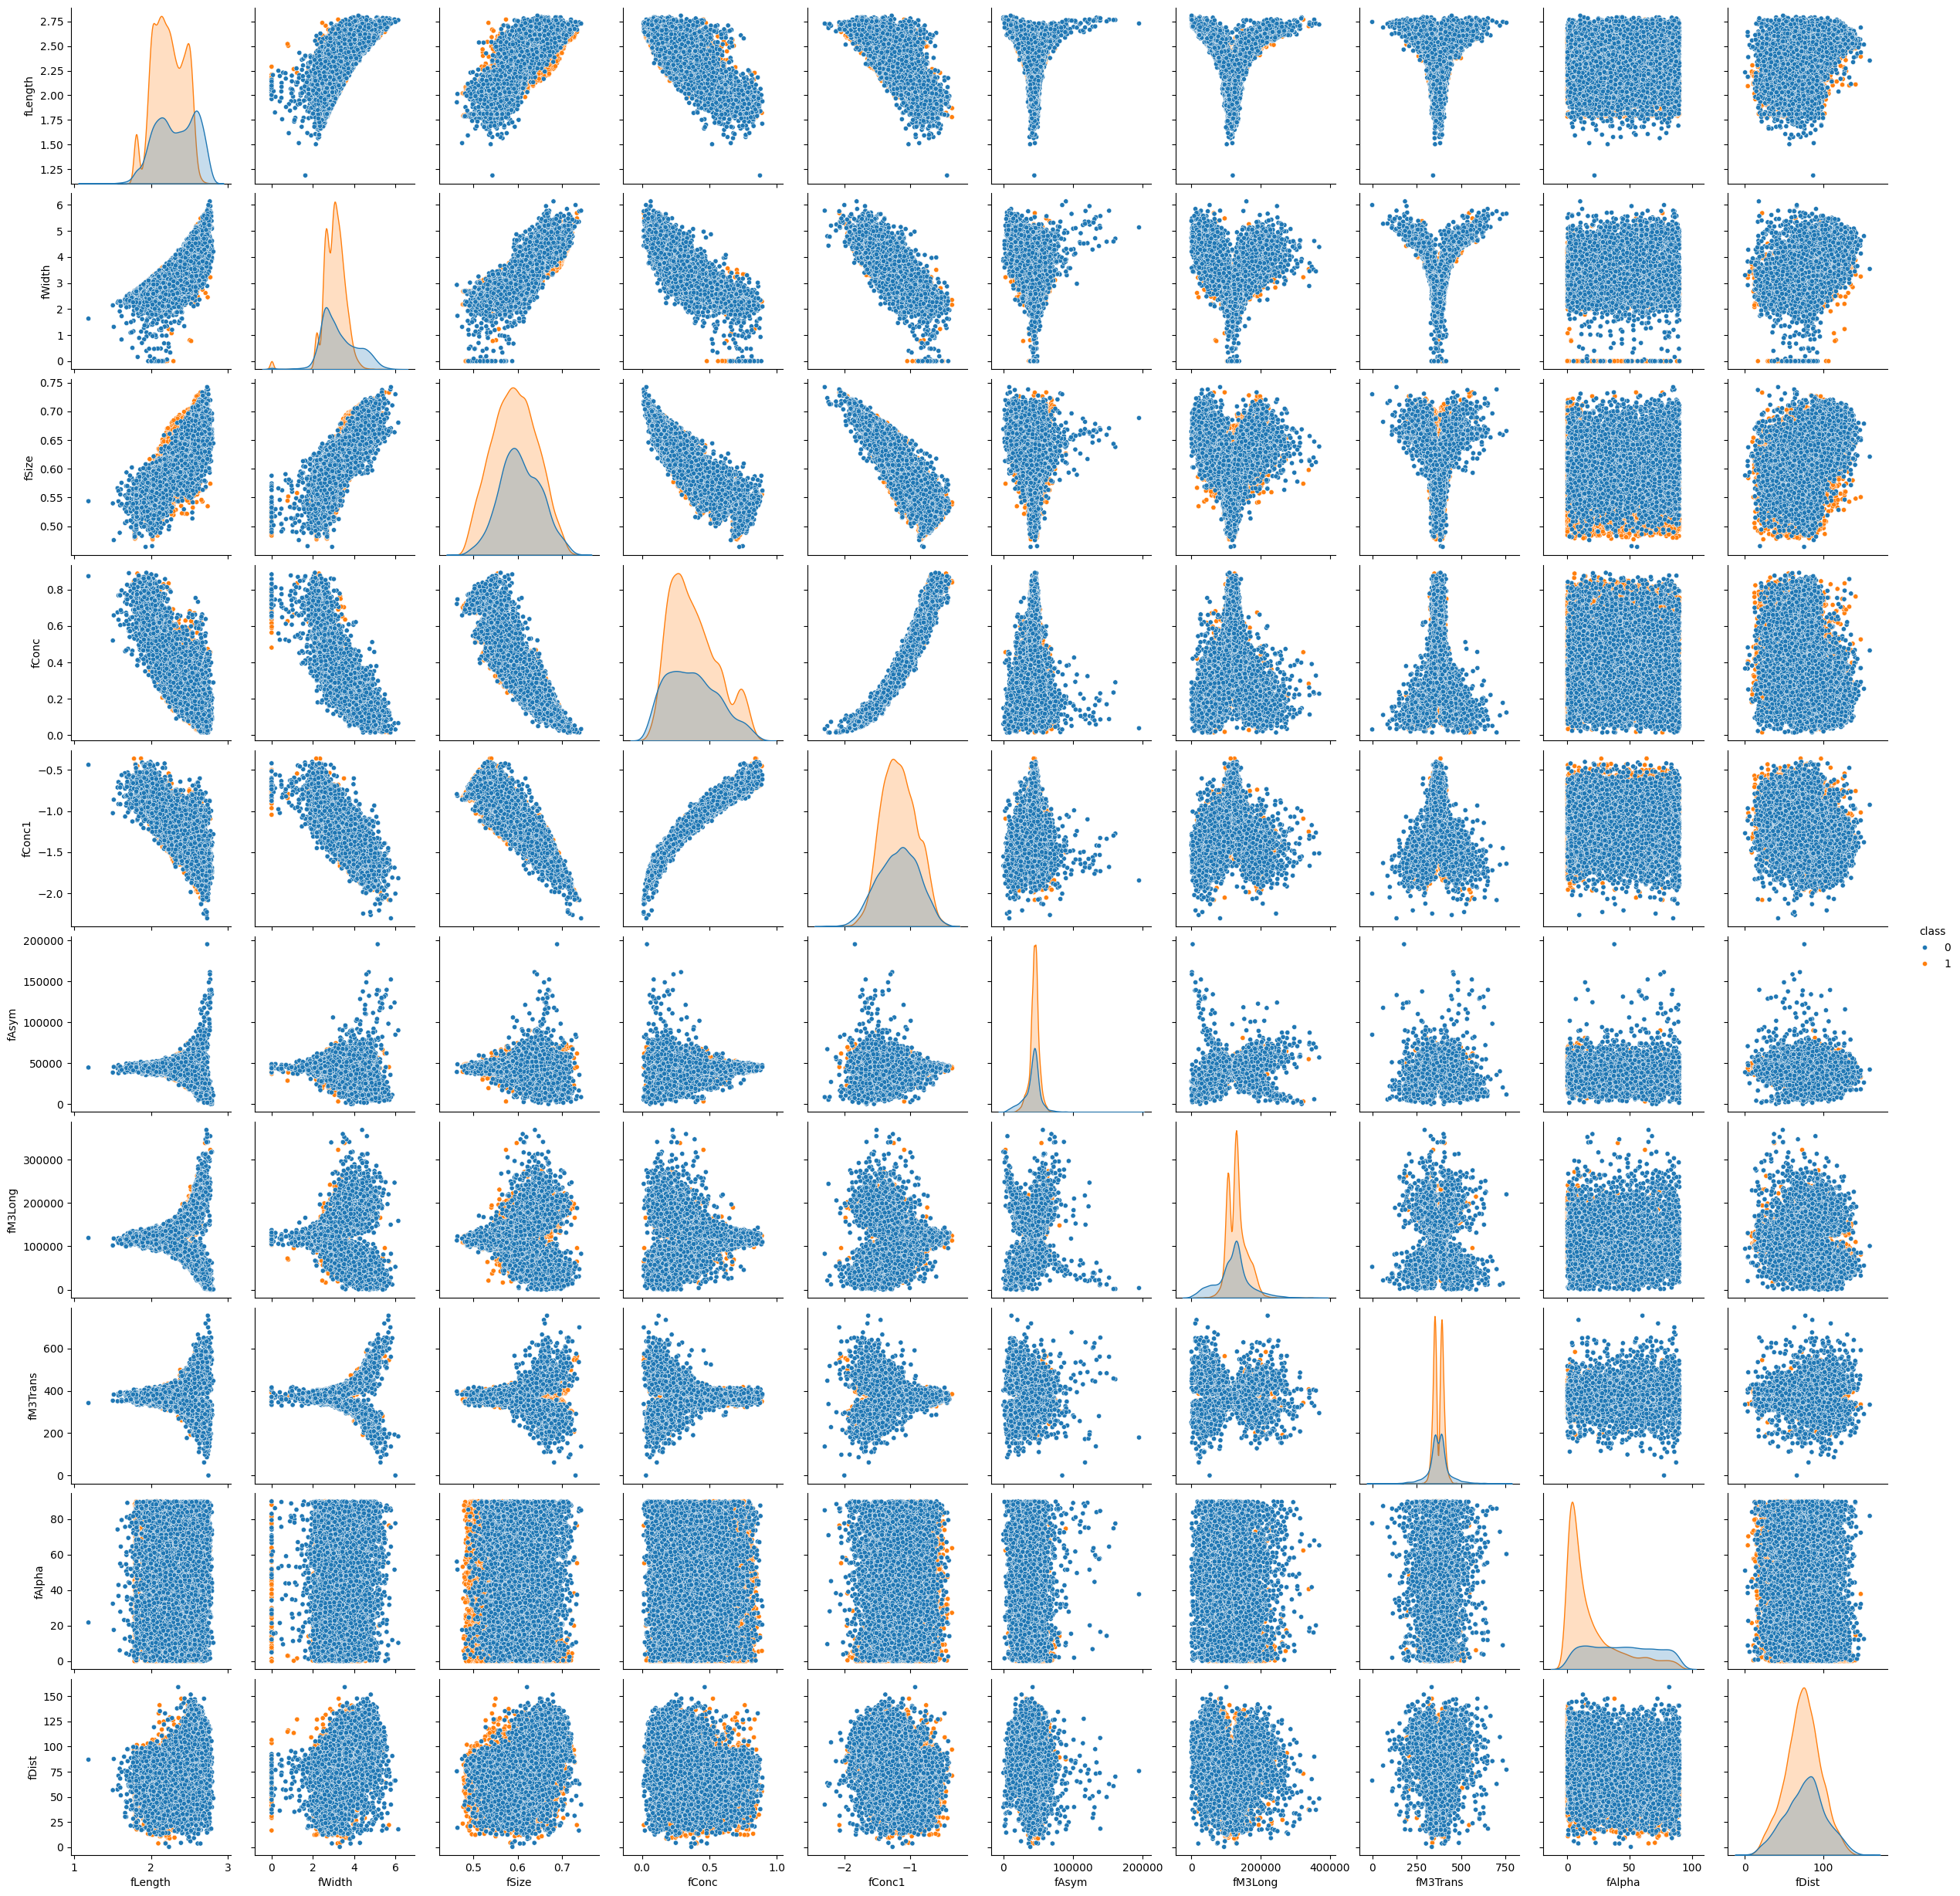

In [52]:
sns.pairplot(
    df,
    corner=False,
    plot_kws={'alpha': 1.0, 's': 20},
    hue='class',  # Pridanie farebného rozlíšenia podľa 'oximetry'
)

In [69]:
# Helper function: Cohen's d effect size
def cohend(d1, d2):
    """
    Calculate Cohen's d for independent samples.
    d1, d2: array-like data for two groups
    Returns: Cohen's d value (standardized mean difference)
    """
    from numpy import var, sqrt, mean
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    
    # calculate the effect size
    return (u1 - u2) / s

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


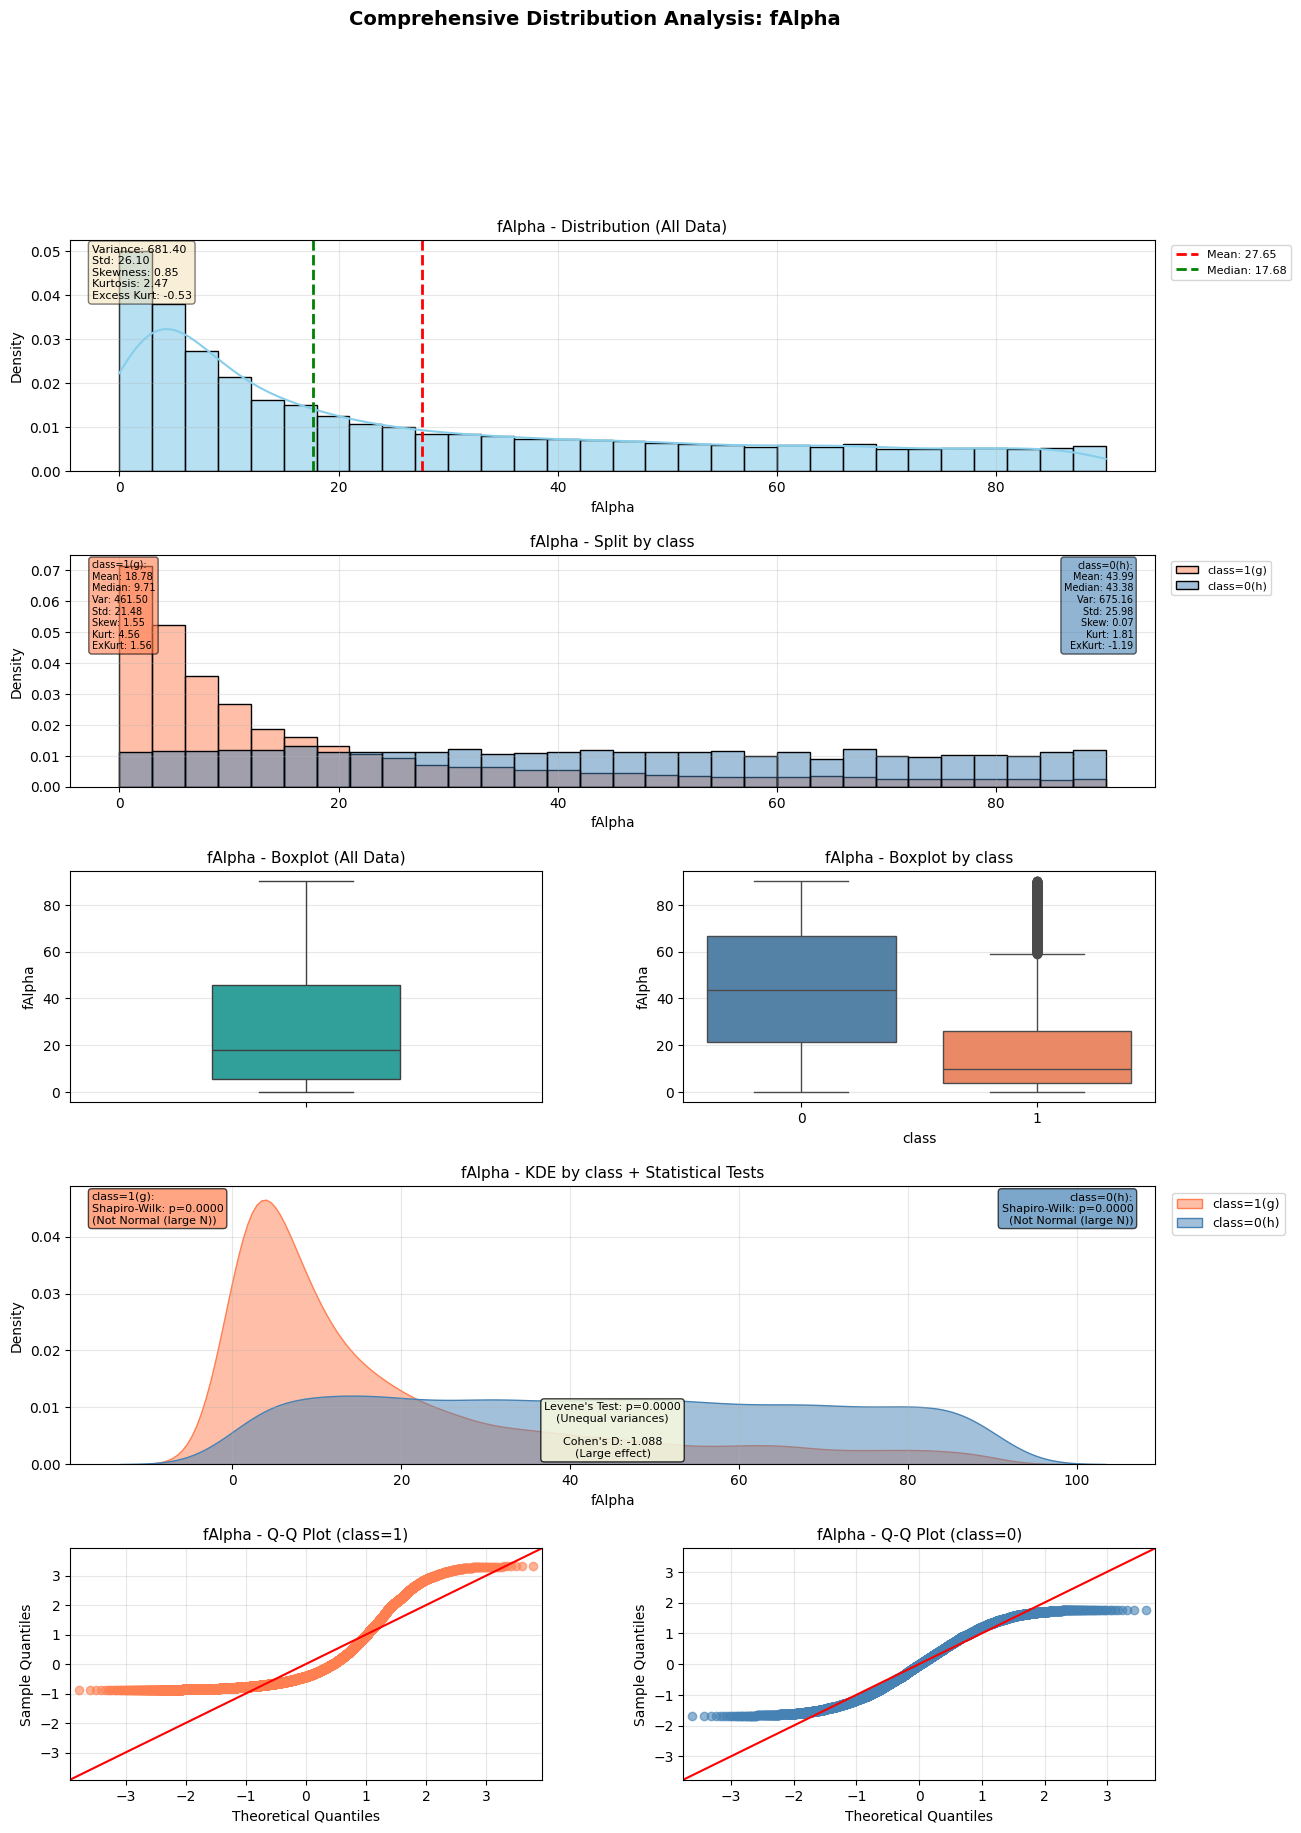

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


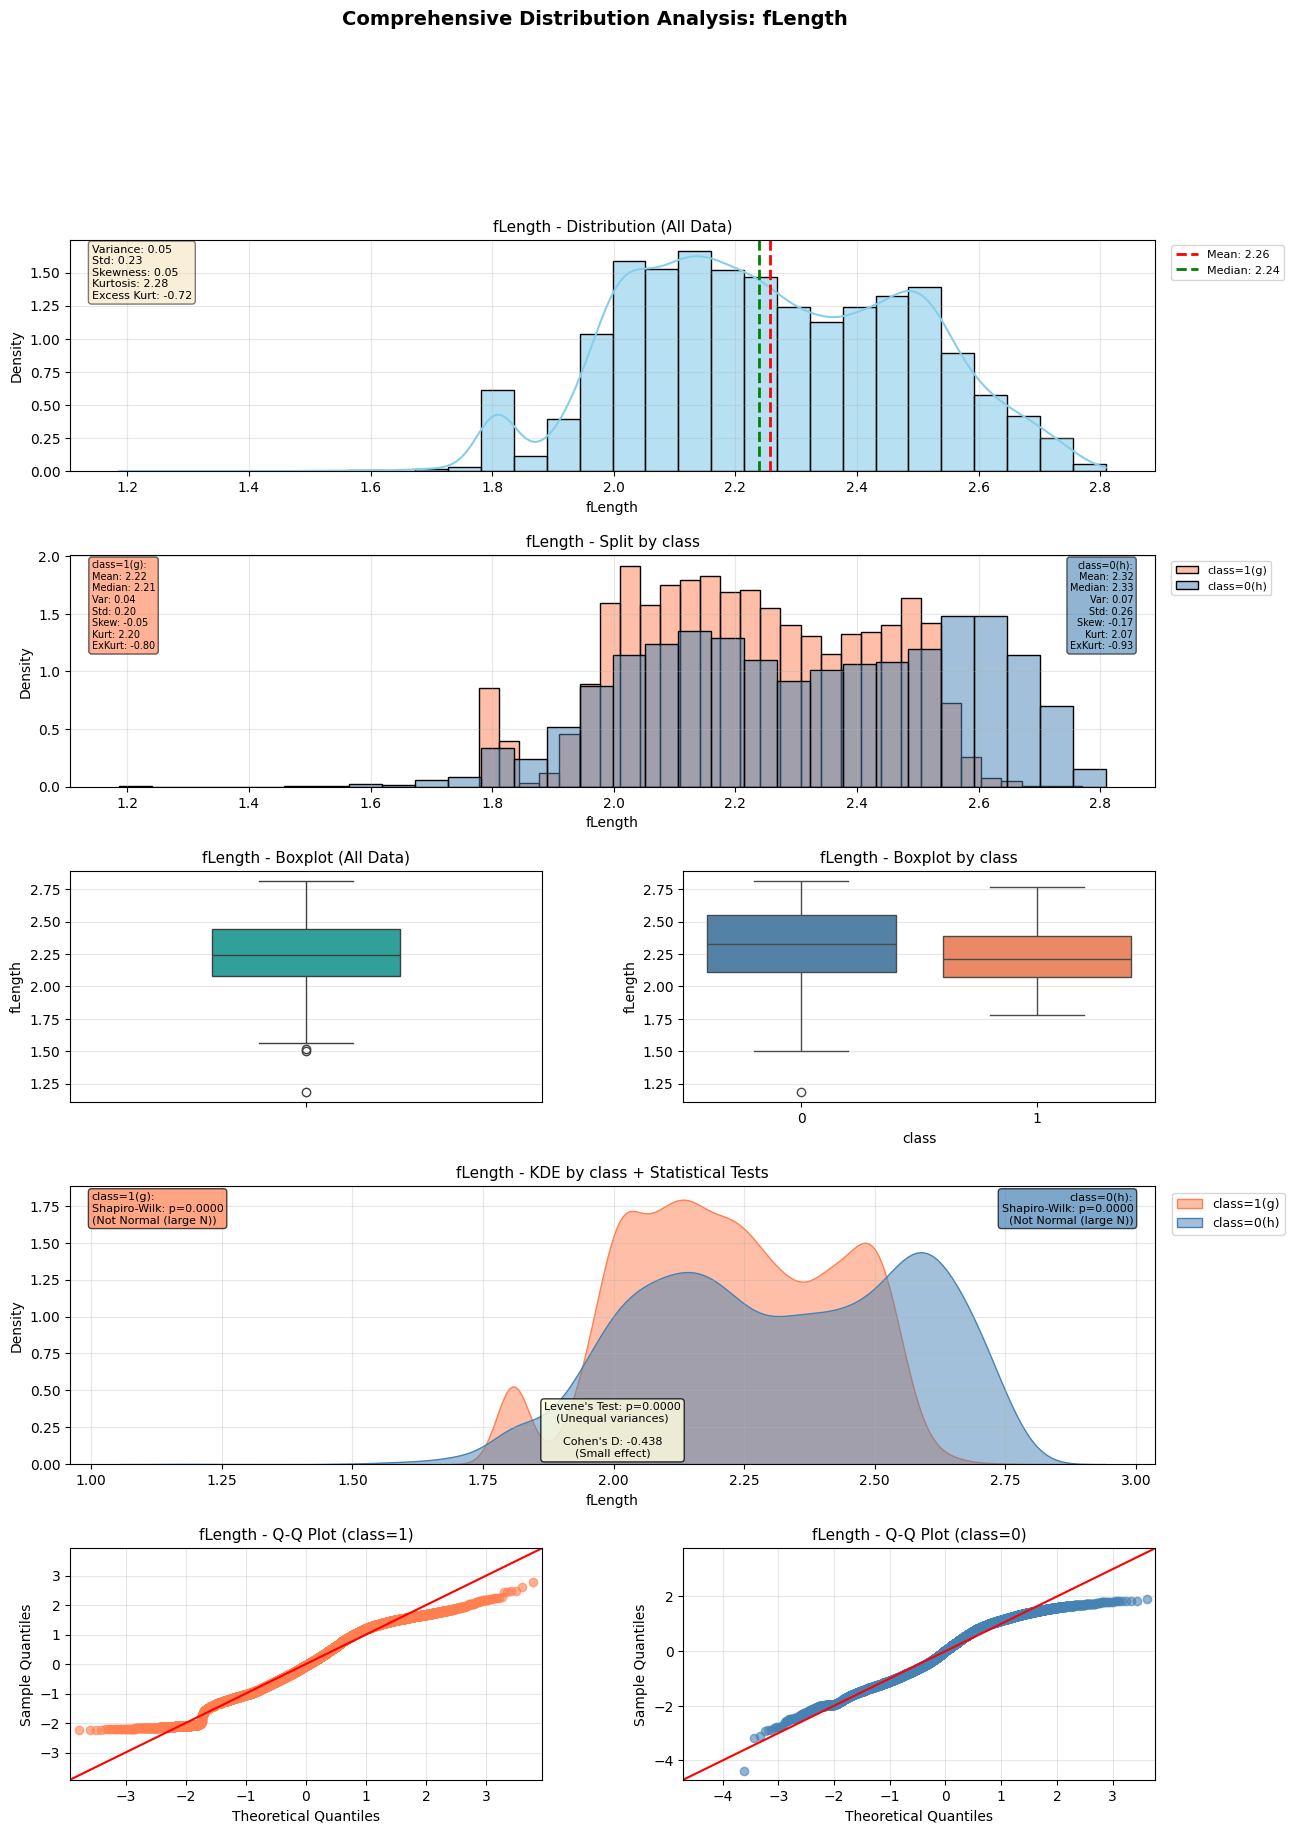

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


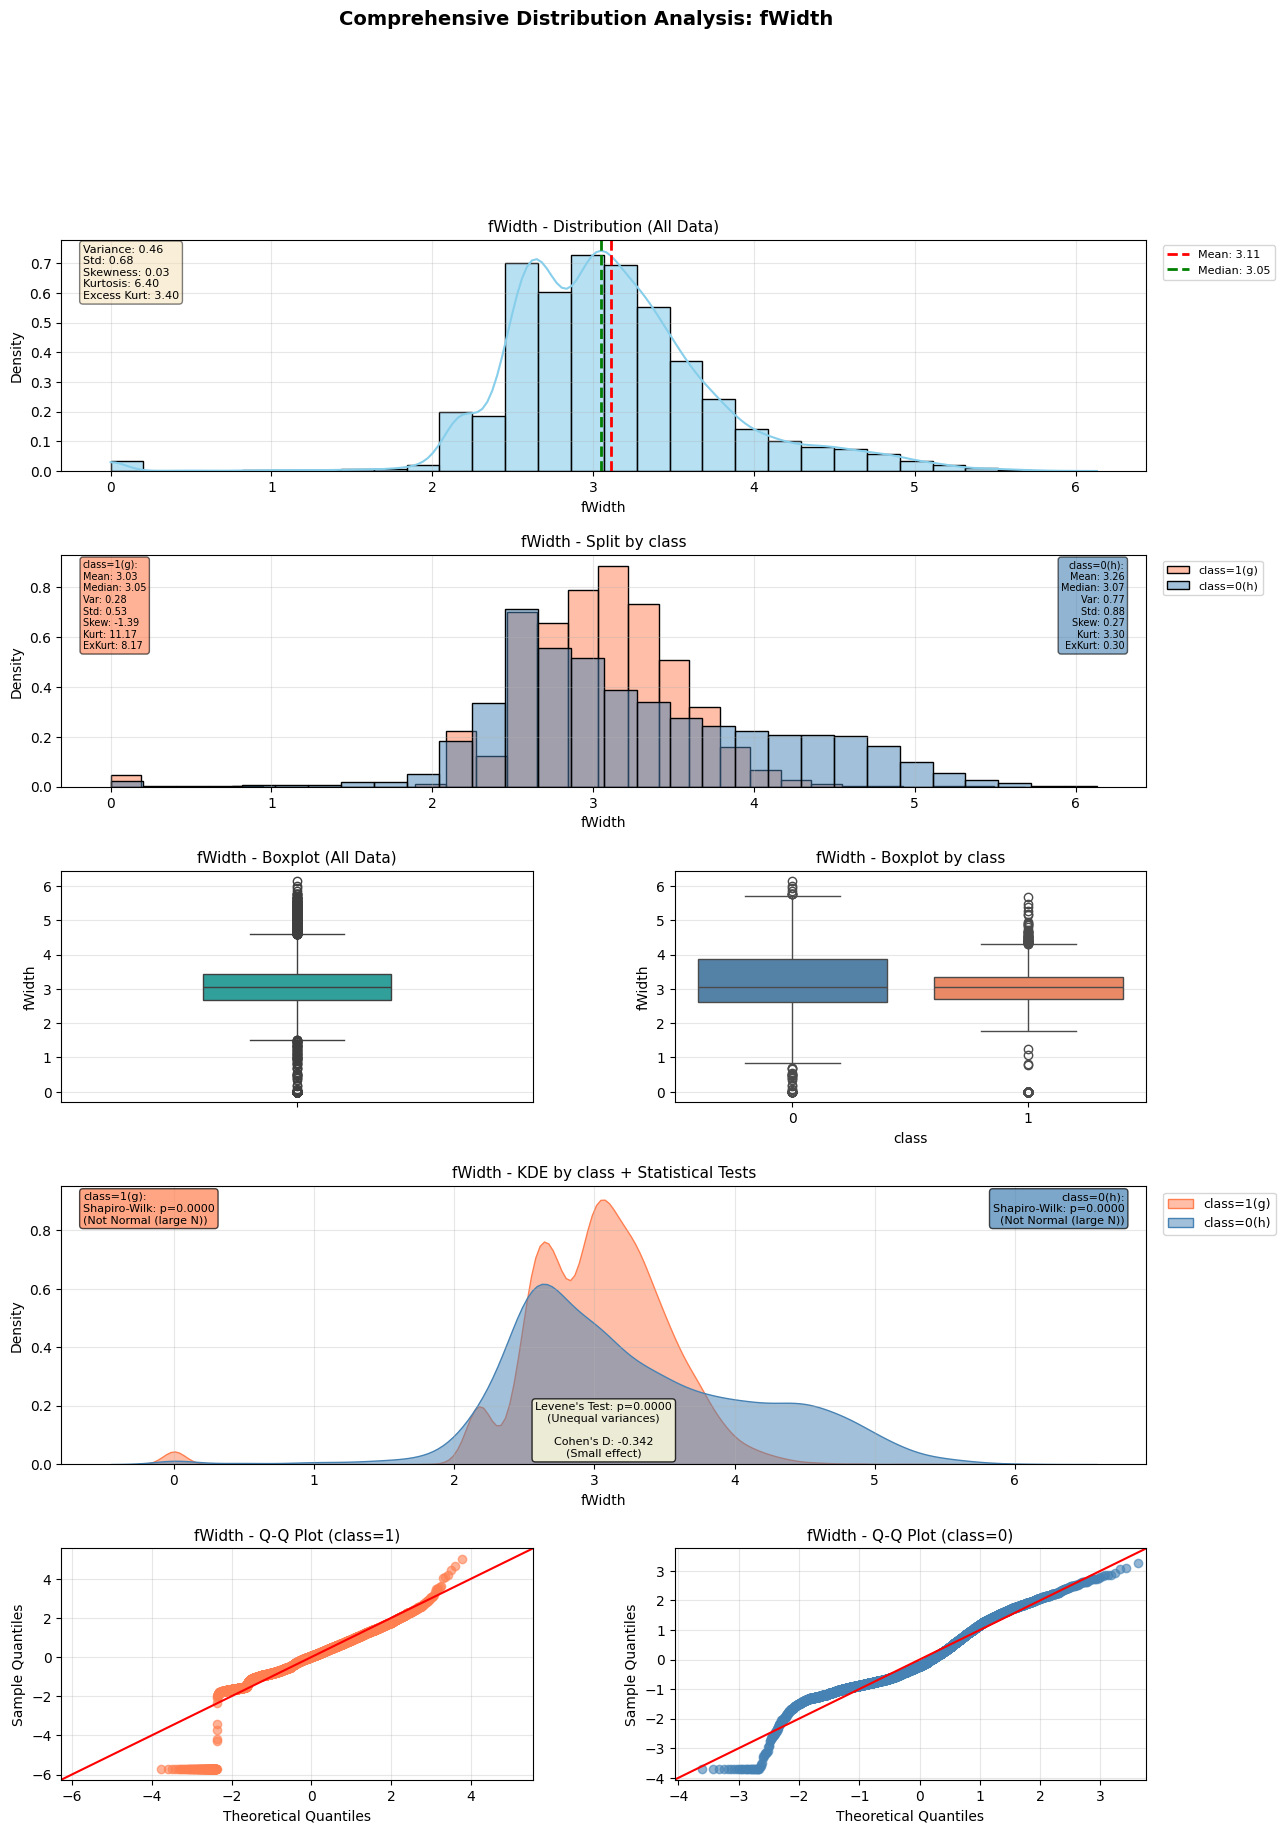

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


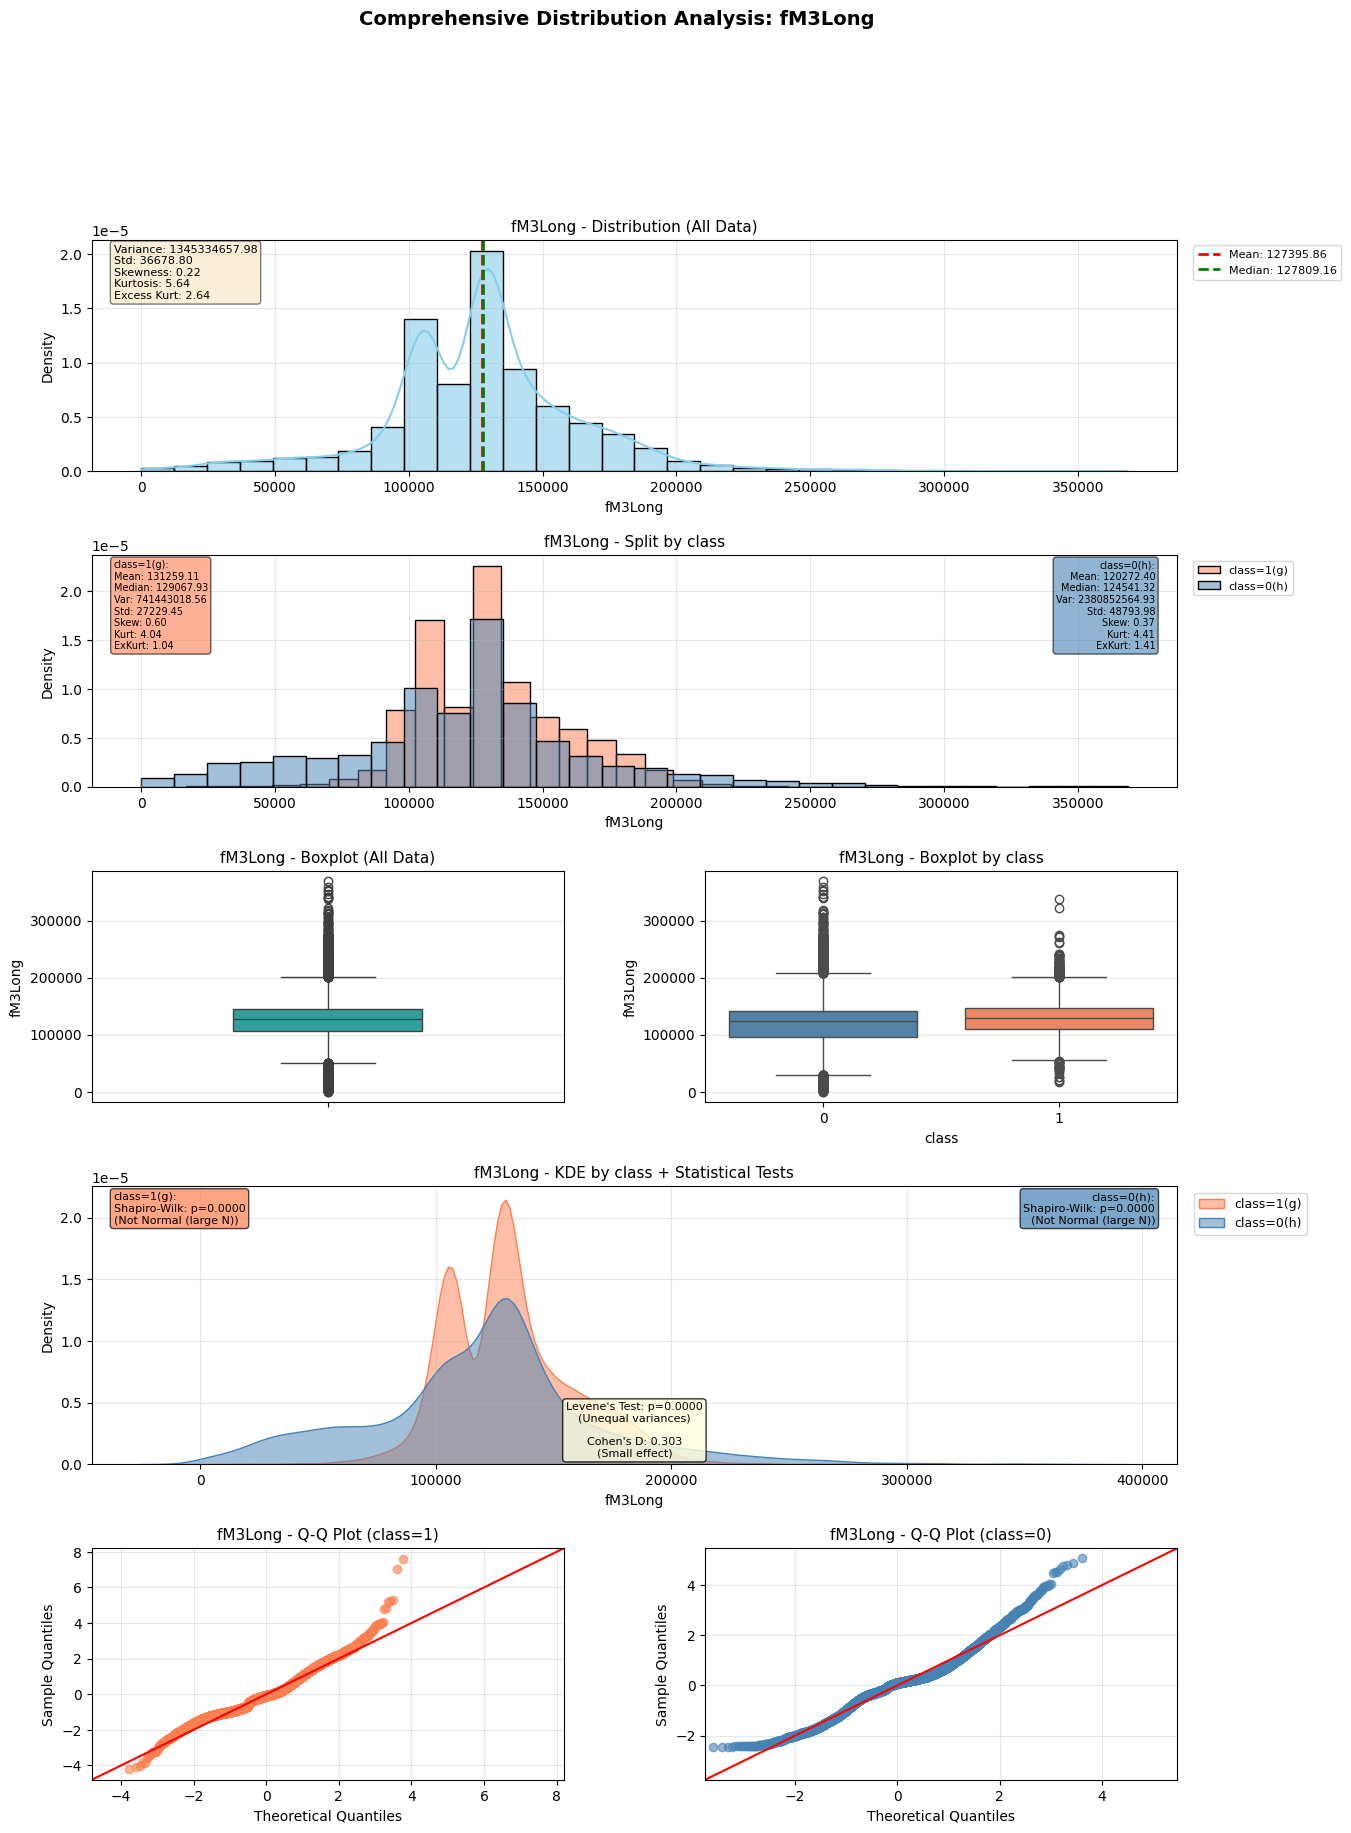

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


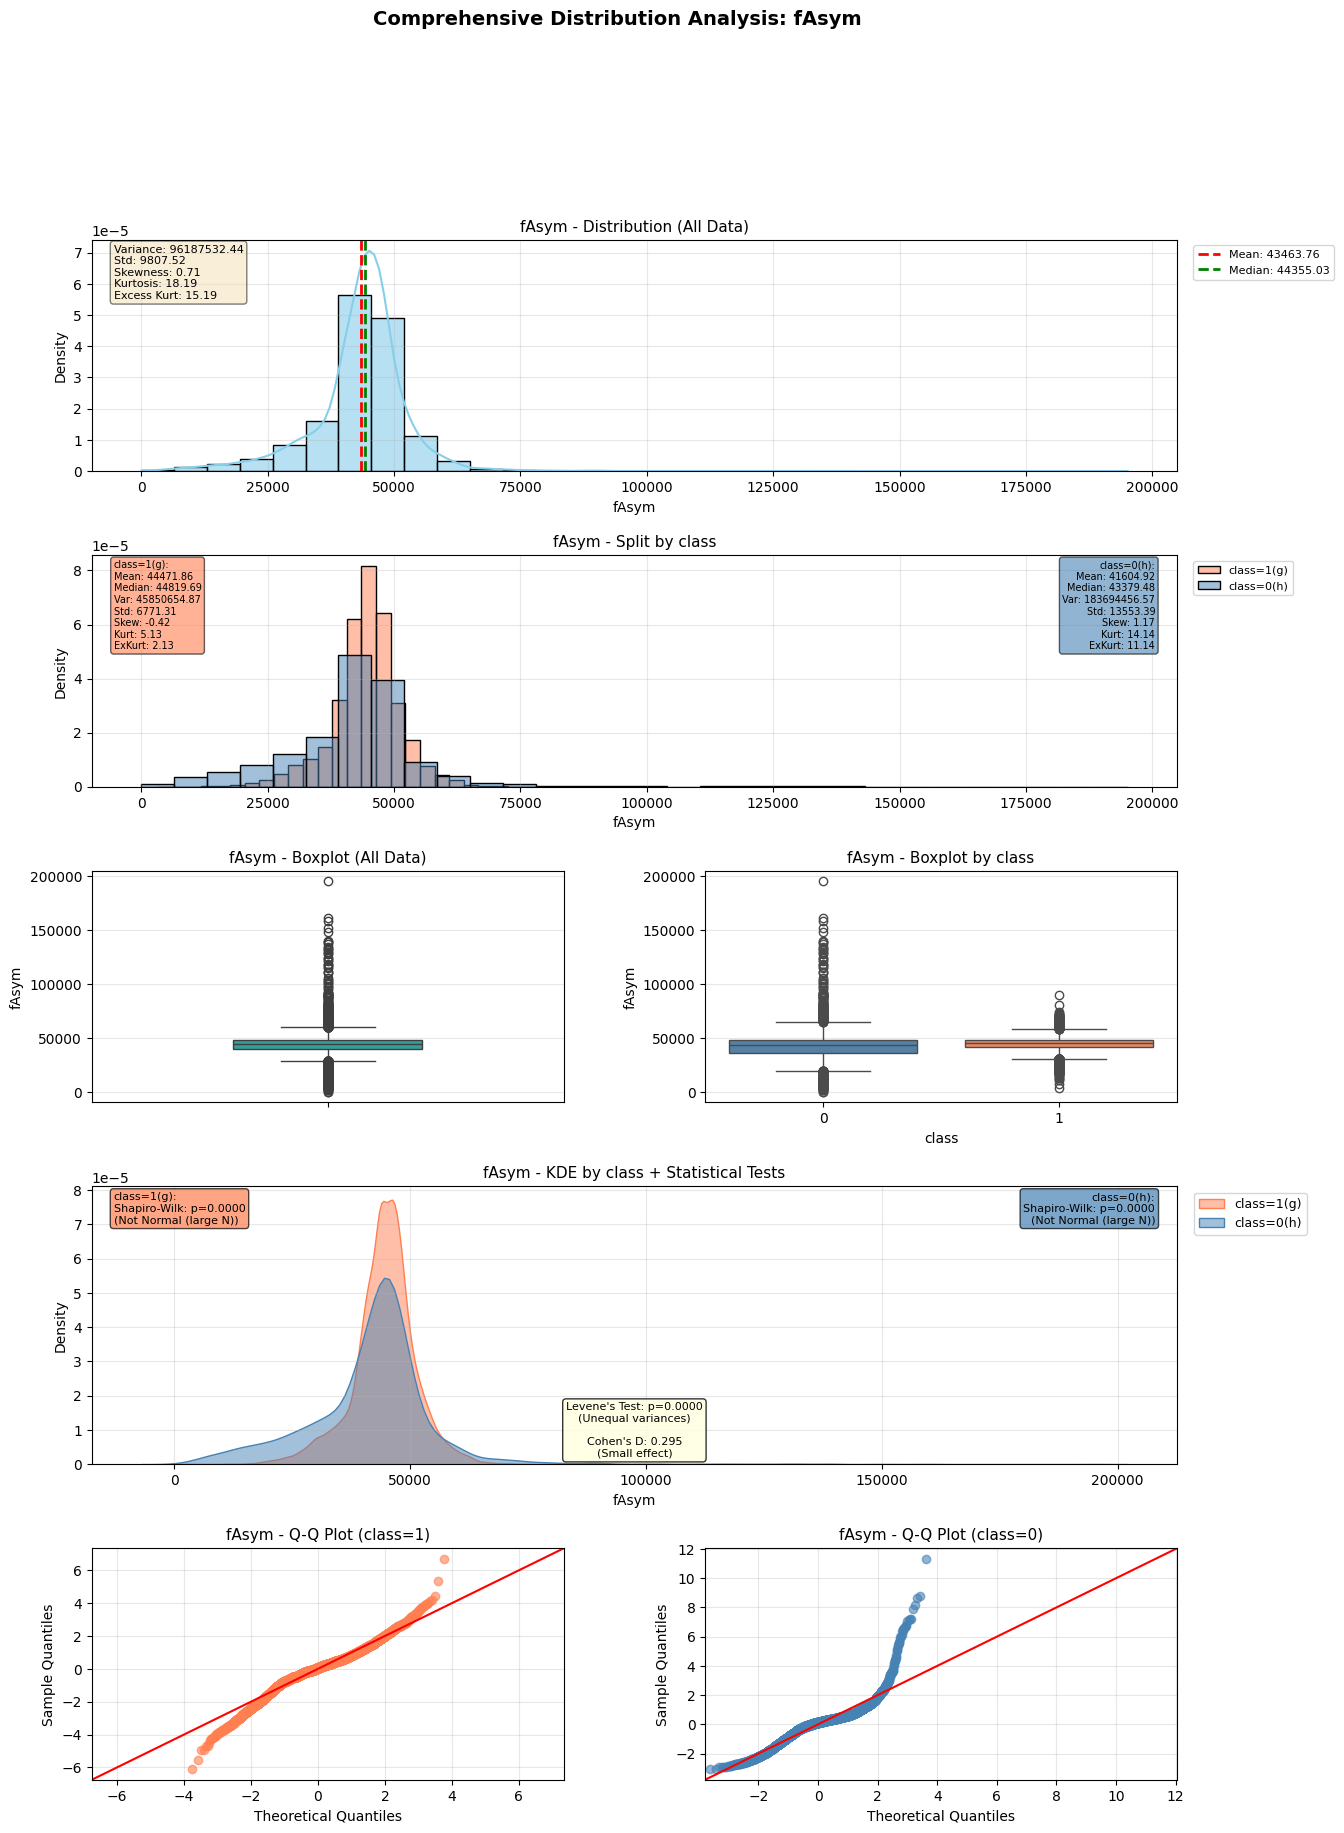

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


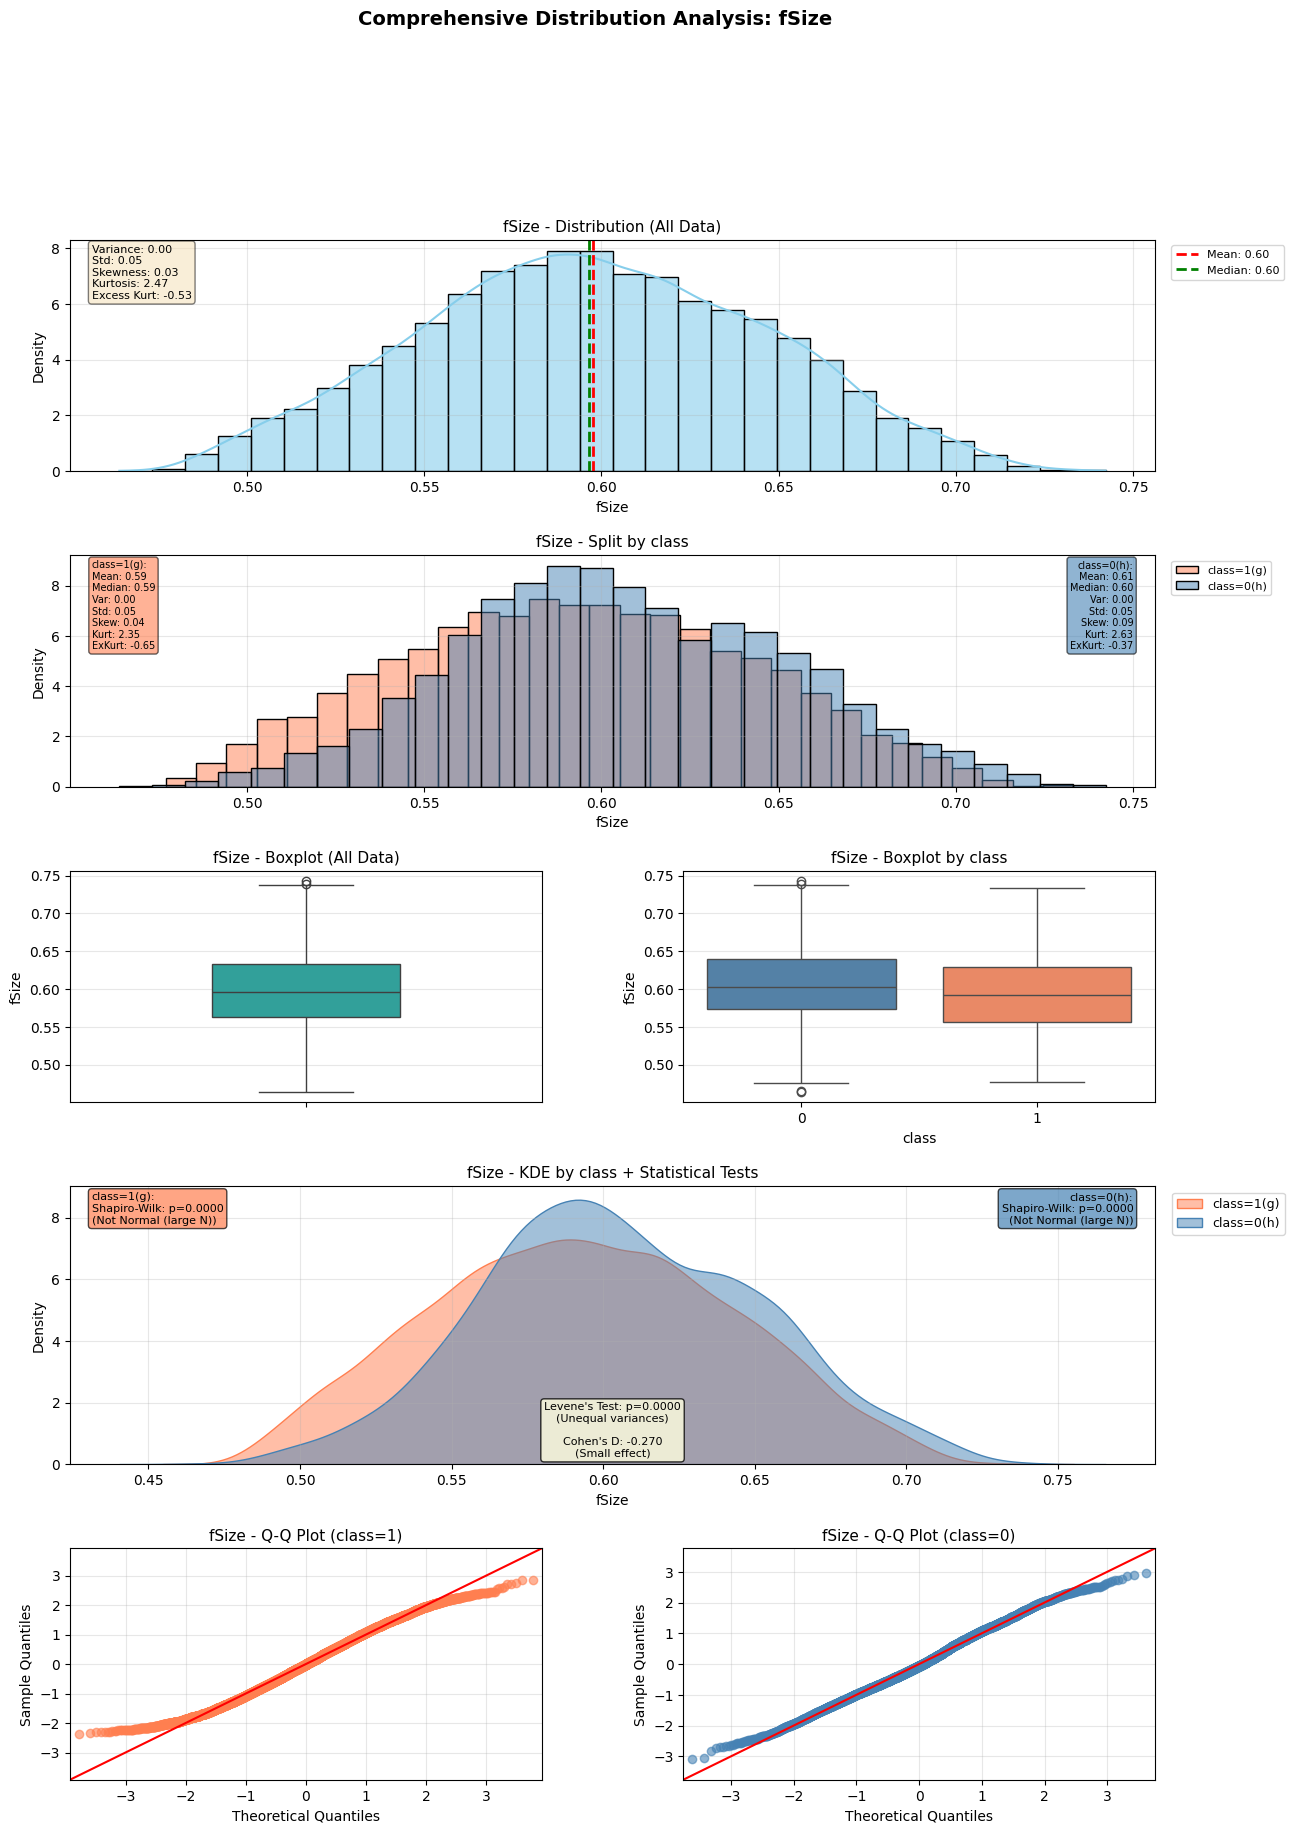

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


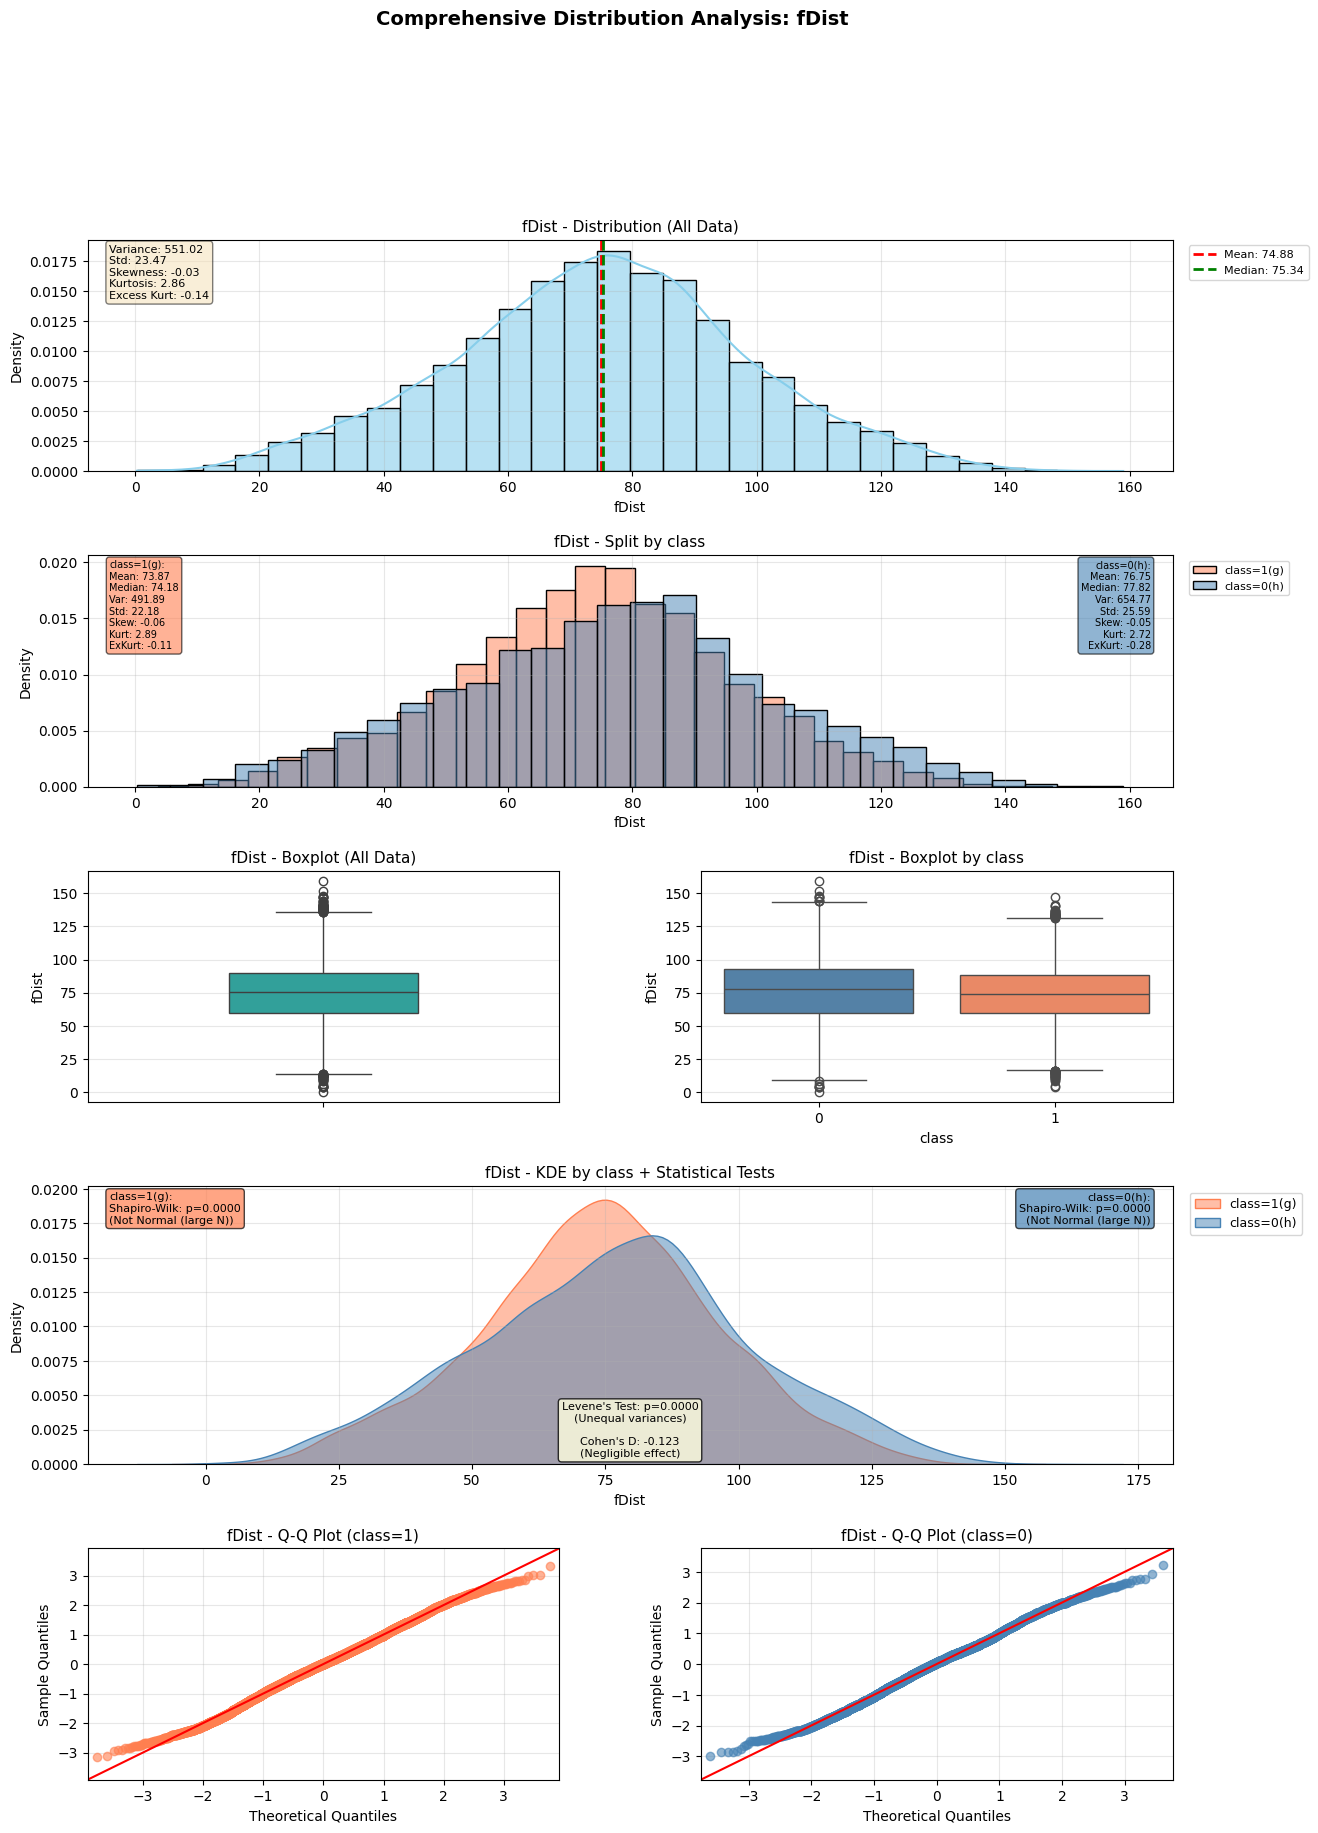

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


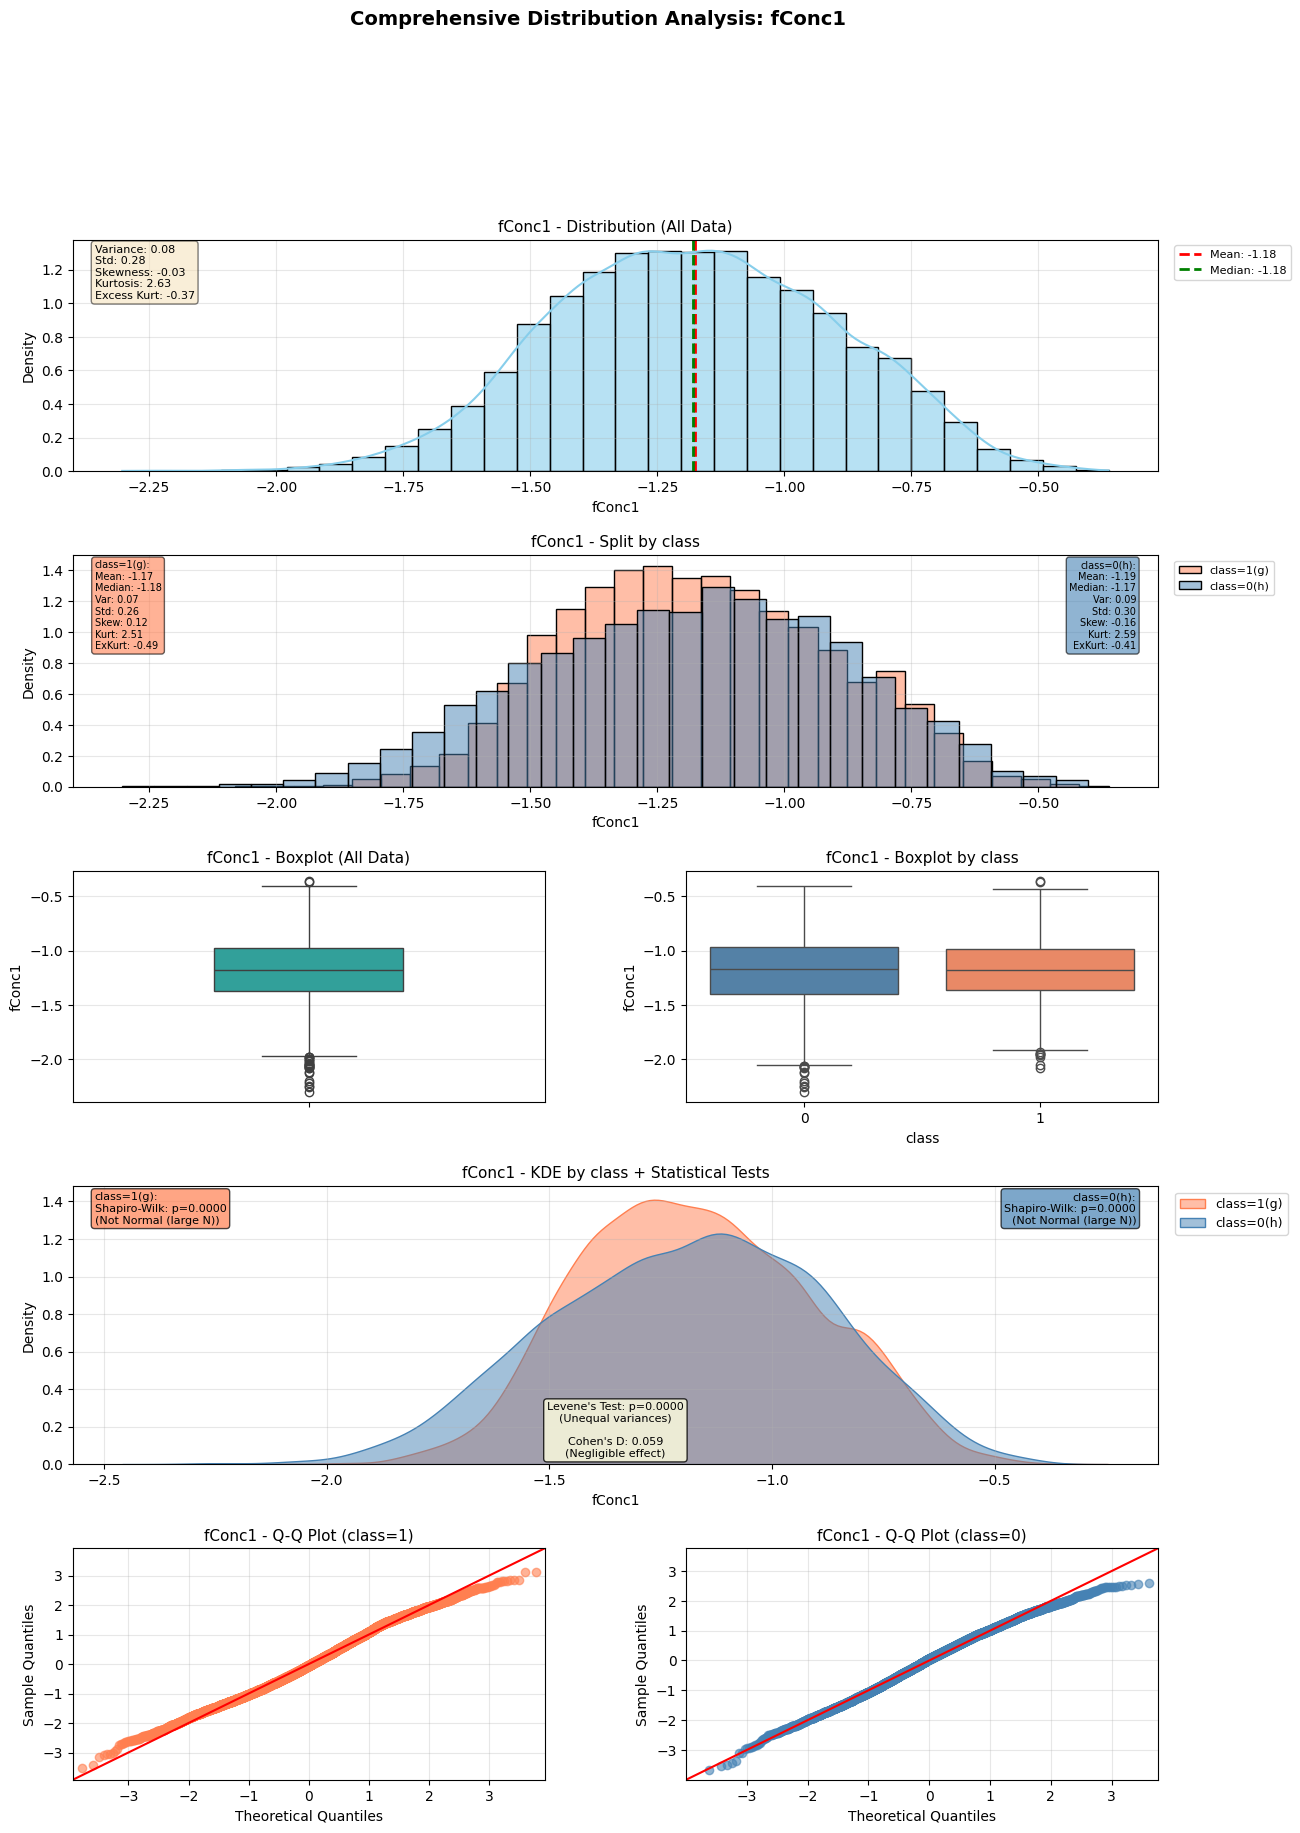

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


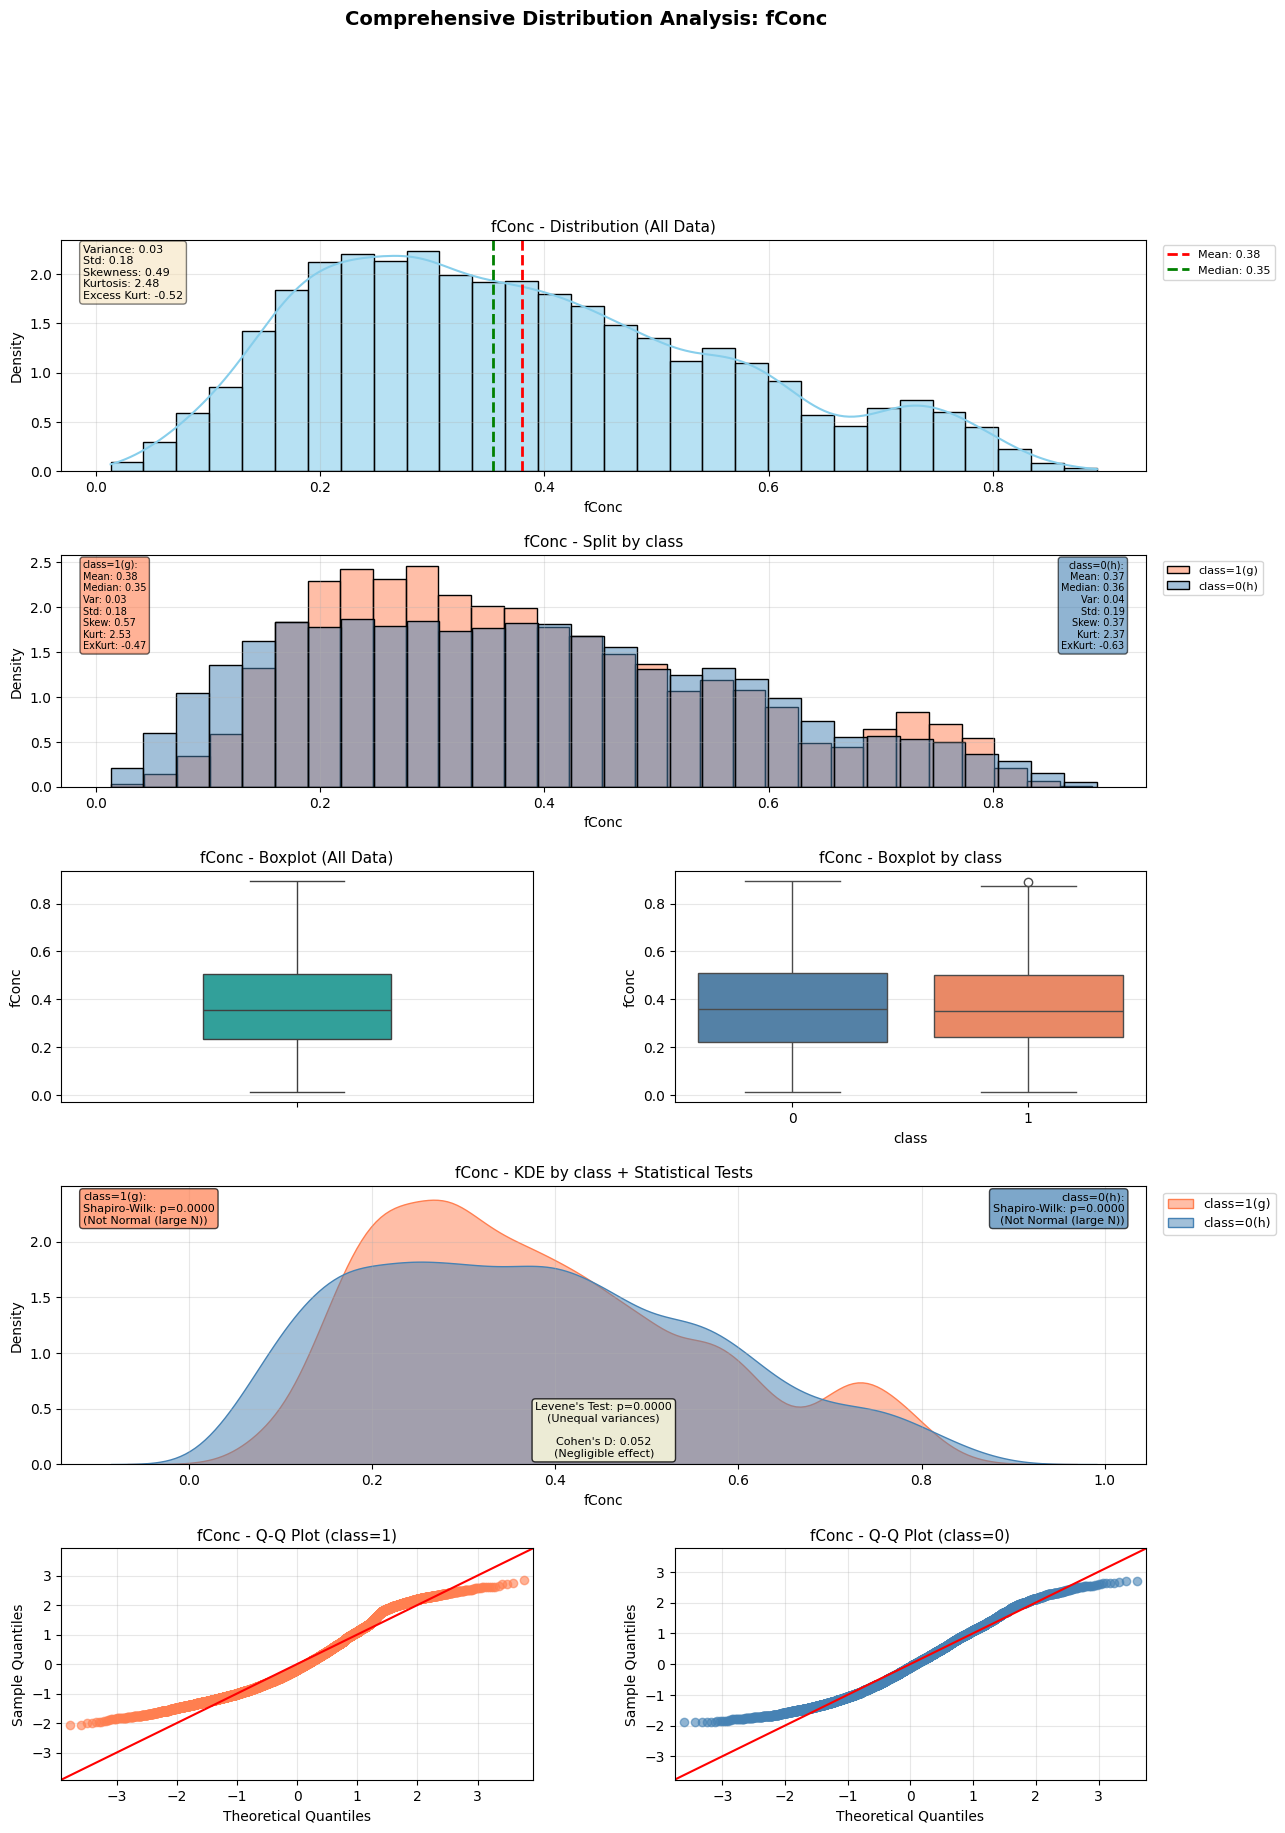

C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12332.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\nikio\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6688.
  res = hypotest_fun_out(*samples, **kwds)


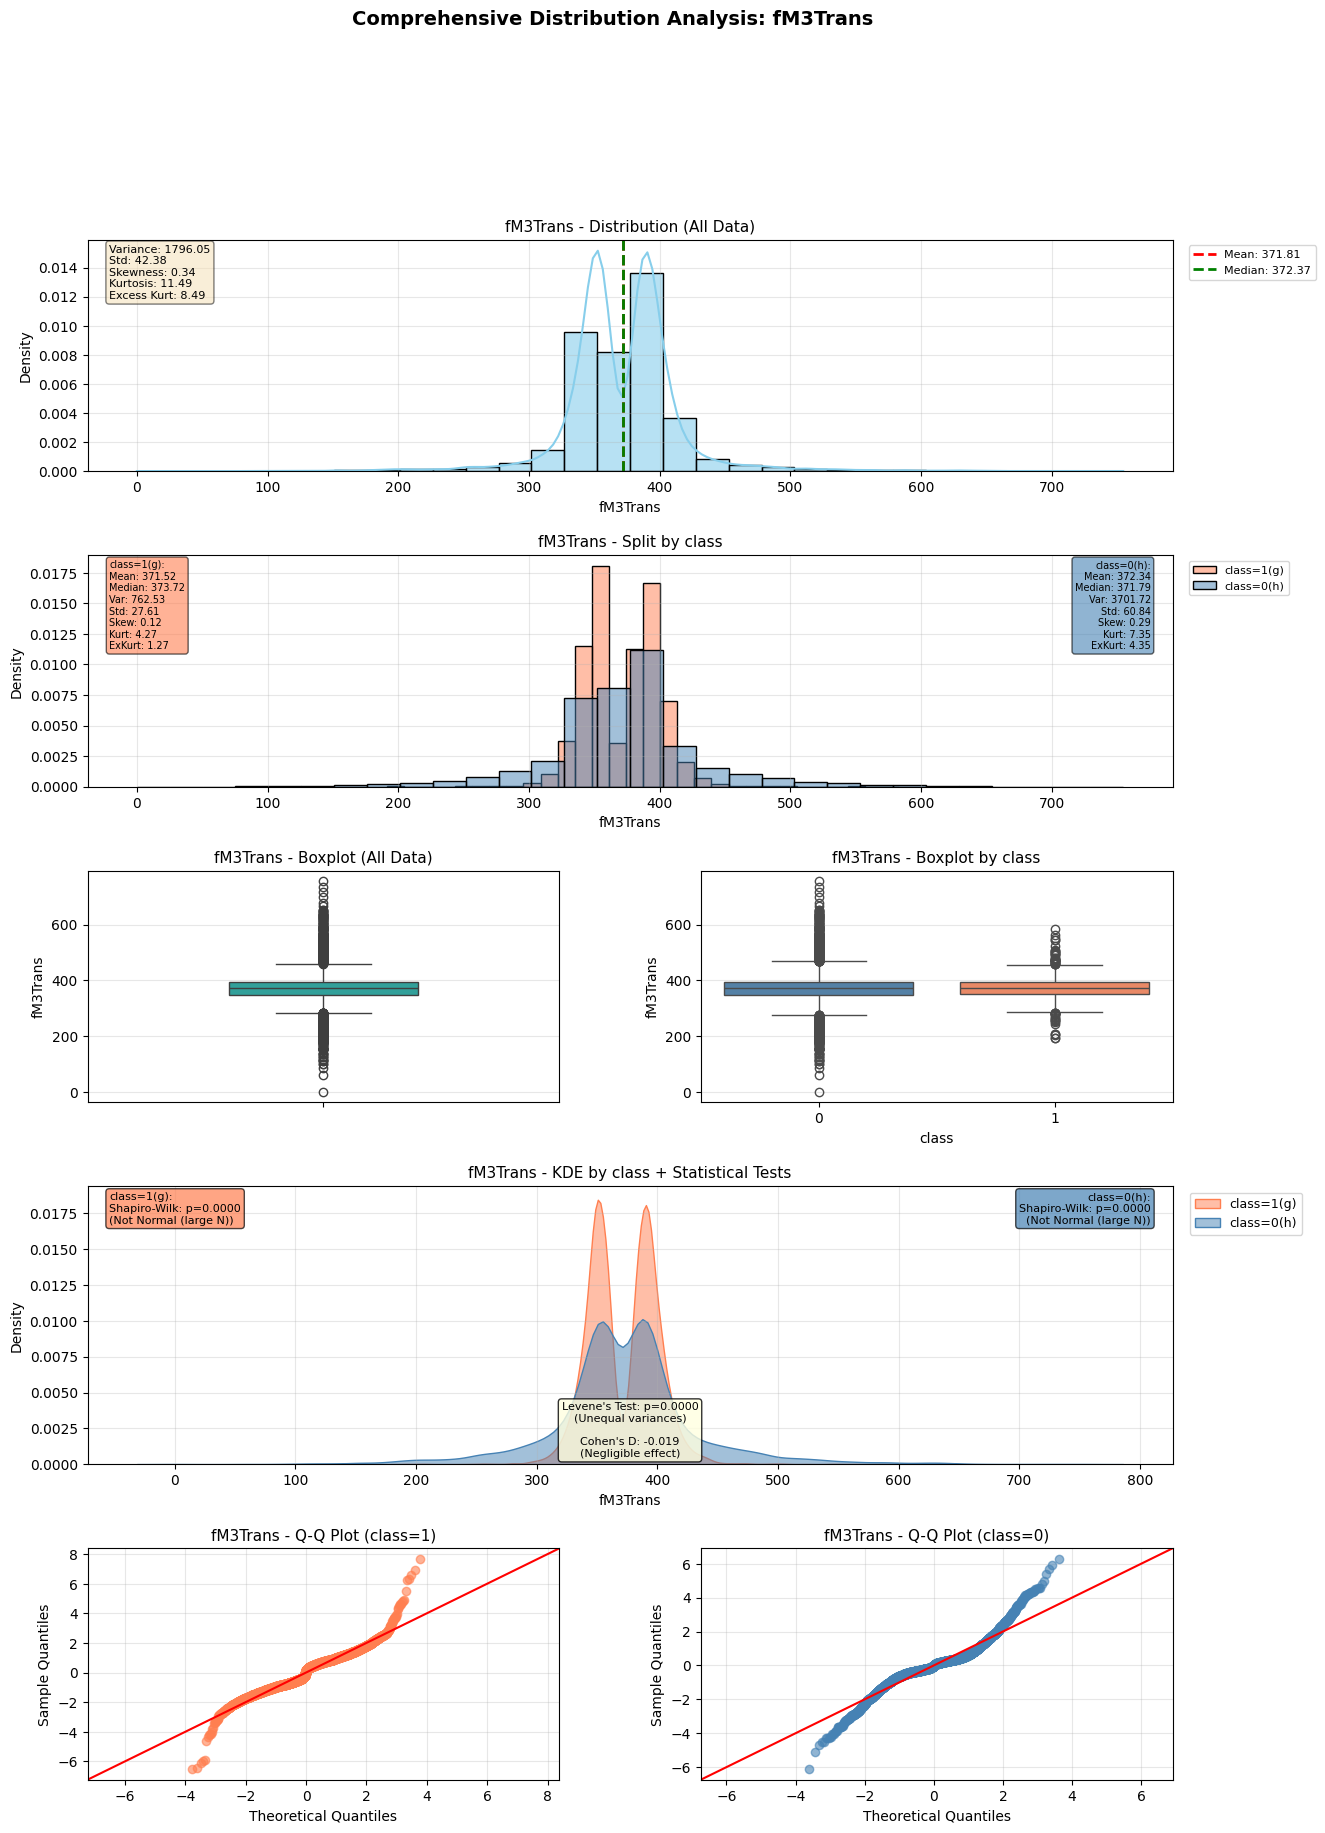

In [71]:
import statsmodels.api as sm

# Sort cols_to_visualize by absolute correlation with 'class' (descending)
correlations = numeric_df.corr()['class'].abs()
cols_to_visualize = correlations.drop('class').sort_values(ascending=False).index.tolist()

for col in cols_to_visualize:
    # Skip non-numeric columns
    if df[col].dtype not in [np.float64, np.int64, np.float32, np.int32]:
        continue
    
    # Prepare data
    data_all = df[col].dropna()
    data_g = df[df['class'] == 1][col].dropna()  # class=1 ('g')
    data_h = df[df['class'] == 0][col].dropna()  # class=0 ('h')
    
    # Skip if insufficient data
    if len(data_g) < 3 or len(data_h) < 3:
        continue
    
    # Create figure with GridSpec (5 rows)
    fig = plt.figure(figsize=(14, 20))
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 1, 1, 1.2, 1], hspace=0.35, wspace=0.3)
    
    # ========== ROW 1: Histogram + KDE + Mean/Median lines (full width) ==========
    ax1 = fig.add_subplot(gs[0, :])
    sns.histplot(data_all, bins=30, kde=True, color='skyblue', ax=ax1, stat='density', alpha=0.6)
    
    # Calculate statistics
    mean_all = data_all.mean()
    median_all = data_all.median()
    variance_all = data_all.var()
    std_all = data_all.std()
    skewness_all = stats.skew(data_all)
    kurt_all = stats.kurtosis(data_all, fisher=False)  # regular kurtosis
    excess_kurt_all = stats.kurtosis(data_all, fisher=True)  # excess kurtosis
    
    # Add vertical lines for mean and median
    ax1.axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_all:.2f}')
    ax1.axvline(median_all, color='green', linestyle='--', linewidth=2, label=f'Median: {median_all:.2f}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax1.set_title(f'{col} - Distribution (All Data)', fontsize=11)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Density')
    ax1.grid(True, alpha=0.3)
    
    # Add text box with statistics
    textstr1 = f'Variance: {variance_all:.2f}\nStd: {std_all:.2f}\nSkewness: {skewness_all:.2f}\nKurtosis: {kurt_all:.2f}\nExcess Kurt: {excess_kurt_all:.2f}'
    ax1.text(0.02, 0.98, textstr1, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # ========== ROW 2: Overlaid Histograms (class split, full width) ==========
    ax2 = fig.add_subplot(gs[1, :])
    color_0 = 'coral'
    color_1 = 'steelblue'
    
    sns.histplot(data_g, bins=30, color=color_0, alpha=0.5, label=f'class={class_mapping['g']}(g)', ax=ax2, stat='density')
    sns.histplot(data_h, bins=30, color=color_1, alpha=0.5, label=f'class={class_mapping['h']}(h)', ax=ax2, stat='density')
    
    # Calculate statistics for each group
    mean_0, median_0 = data_g.mean(), data_g.median()
    variance_0, std_0 = data_g.var(), data_g.std()
    skewness_0 = stats.skew(data_g)
    kurt_0 = stats.kurtosis(data_g, fisher=False)
    excess_kurt_0 = stats.kurtosis(data_g, fisher=True)
    
    mean_1, median_1 = data_h.mean(), data_h.median()
    variance_1, std_1 = data_h.var(), data_h.std()
    skewness_1 = stats.skew(data_h)
    kurt_1 = stats.kurtosis(data_h, fisher=False)
    excess_kurt_1 = stats.kurtosis(data_h, fisher=True)
    
    ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=True)
    ax2.set_title(f'{col} - Split by class', fontsize=11)
    ax2.set_xlabel(col)
    ax2.set_ylabel('Density')
    ax2.grid(True, alpha=0.3)
    
    # Text boxes for each group (color-coded)
    textstr_0 = f'class={class_mapping['g']}(g):\nMean: {mean_0:.2f}\nMedian: {median_0:.2f}\nVar: {variance_0:.2f}\nStd: {std_0:.2f}\nSkew: {skewness_0:.2f}\nKurt: {kurt_0:.2f}\nExKurt: {excess_kurt_0:.2f}'
    textstr_1 = f'class={class_mapping['h']}(h):\nMean: {mean_1:.2f}\nMedian: {median_1:.2f}\nVar: {variance_1:.2f}\nStd: {std_1:.2f}\nSkew: {skewness_1:.2f}\nKurt: {kurt_1:.2f}\nExKurt: {excess_kurt_1:.2f}'

    ax2.text(0.02, 0.98, textstr_0, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.6))
    ax2.text(0.98, 0.98, textstr_1, transform=ax2.transAxes, fontsize=7,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.6))
    
    # ========== ROW 3, PLOT 1: Boxplot (all data) ==========
    ax3 = fig.add_subplot(gs[2, 0])
    sns.boxplot(y=data_all, color='lightseagreen', ax=ax3, width=0.4)
    ax3.set_title(f'{col} - Boxplot (All Data)', fontsize=11)
    ax3.set_ylabel(col)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 3, PLOT 2: Boxplots (split by class) - FIXED ==========
    ax4 = fig.add_subplot(gs[2, 1])
    df_temp = df[[col, 'class']].dropna()
    sns.boxplot(x='class', y=col, data=df_temp, hue='class', palette=[color_1, color_0], ax=ax4, legend=False)
    ax4.set_title(f'{col} - Boxplot by class', fontsize=11)
    ax4.set_xlabel('class')
    ax4.set_ylabel(col)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========== ROW 4: Wide KDE plot + Statistical tests ==========
    ax5 = fig.add_subplot(gs[3, :])
    sns.kdeplot(data_g, fill=True, color=color_0, label=f'class={class_mapping['g']}(g)', alpha=0.5, ax=ax5)
    sns.kdeplot(data_h, fill=True, color=color_1, label=f'class={class_mapping['h']}(h)', alpha=0.5, ax=ax5)
    ax5.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=9, frameon=True)
    ax5.set_title(f'{col} - KDE by class + Statistical Tests', fontsize=11)
    ax5.set_xlabel(col)
    ax5.set_ylabel('Density')
    ax5.grid(True, alpha=0.3)
    
    # Statistical tests
    # Shapiro-Wilk for each group
    shapiro_0 = stats.shapiro(data_g)
    shapiro_1 = stats.shapiro(data_h)
    
    shapiro_interp_0 = 'Normal' if shapiro_0.pvalue > 0.05 else 'Not Normal'
    shapiro_interp_1 = 'Normal' if shapiro_1.pvalue > 0.05 else 'Not Normal'
    
    # Add note if sample size is large
    note_0 = " (large N)" if len(data_g) > 5000 else ""
    note_1 = " (large N)" if len(data_h) > 5000 else ""
    
    # Levene's test (variance equality)
    levene_test = stats.levene(data_g, data_h)
    levene_interp = 'Equal variances' if levene_test.pvalue > 0.05 else 'Unequal variances'
    
    # Cohen's D
    cohens_d = cohend(data_g, data_h)
    if abs(cohens_d) < 0.2:
        effect_interp = 'Negligible'
    elif abs(cohens_d) < 0.5:
        effect_interp = 'Small'
    elif abs(cohens_d) < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'
    
    # Text boxes for statistical tests
    textstr_tests_0 = f"class={class_mapping['g']}(g):\nShapiro-Wilk: p={shapiro_0.pvalue:.4f}\n({shapiro_interp_0}{note_0})"
    textstr_tests_1 = f"class={class_mapping['h']}(h):\nShapiro-Wilk: p={shapiro_1.pvalue:.4f}\n({shapiro_interp_1}{note_1})"
    textstr_tests_combined = f"Levene's Test: p={levene_test.pvalue:.4f}\n({levene_interp})\n\nCohen's D: {cohens_d:.3f}\n({effect_interp} effect)"
    
    ax5.text(0.02, 0.98, textstr_tests_0, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color_0, alpha=0.7))
    ax5.text(0.98, 0.98, textstr_tests_1, transform=ax5.transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor=color_1, alpha=0.7))
    ax5.text(0.5, 0.02, textstr_tests_combined, transform=ax5.transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # ========== ROW 5, PLOT 1: Q-Q plot for class=1 ==========
    ax6 = fig.add_subplot(gs[4, 0])
    sm.qqplot(data_g, line='45', ax=ax6, alpha=0.6, fit=True, markerfacecolor=color_0, markeredgecolor=color_0)
    ax6.set_title(f'{col} - Q-Q Plot (class=1)', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # ========== ROW 5, PLOT 2: Q-Q plot for class=0 ==========
    ax7 = fig.add_subplot(gs[4, 1])
    sm.qqplot(data_h, line='45', ax=ax7, alpha=0.6, fit=True, markerfacecolor=color_1, markeredgecolor=color_1)
    ax7.set_title(f'{col} - Q-Q Plot (class=0)', fontsize=11)
    ax7.grid(True, alpha=0.3)
    
    # Final figure title
    fig.suptitle(f'Comprehensive Distribution Analysis: {col}', fontsize=14, fontweight='bold', y=0.995)
    
    plt.show()
    # print(f"Completed visualization for: {col}\n" + "="*60)

## **Hypothesis Testing**

**Test 1 - fAlpha**

In [ ]:
# Data splitting for fAlpha by class
fAlpha_class0 = df[df['class'] == 0]['fAlpha'].dropna()
fAlpha_class1 = df[df['class'] == 1]['fAlpha'].dropna()

fAlpha_class0 = fAlpha_class0.sample(n=150, random_state=42)
fAlpha_class1 = fAlpha_class1.sample(n=150, random_state=42)

# Define colors
color_0 = 'coral'
color_1 = 'steelblue'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fAlpha_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fAlpha_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fAlpha', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fAlpha split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fAlpha', 'class']].dropna()
sns.boxplot(x='class', y='fAlpha', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fAlpha', fontsize=11)
axes[1].set_title('Boxplot - fAlpha by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fAlpha by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [ ]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fAlpha_class0)
shapiro_1 = stats.shapiro(fAlpha_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

In [ ]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fAlpha_class0, fAlpha_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")

In [ ]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fAlpha_class0 has a statistically significantly higher median than group fAlpha_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fAlpha_class0, fAlpha_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fAlpha values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fAlpha values.")

In [ ]:
# Calculate Cohen's d for fAlpha between class 0 and 1 groups

c_d = cohend(fAlpha_class1, fAlpha_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fAlpha between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fAlpha_class0), 0.05, None, 1)
print(f"Statistical power of the test for fAlpha between class=0 and class=1: {stat_power:.6f}")

**Test 2 - fLength**

In [ ]:
# Data splitting for fLength by class
fLength_class0 = df[df['class'] == 0]['fLength'].dropna()
fLength_class1 = df[df['class'] == 1]['fLength'].dropna()

fLength_class0 = fLength_class0.sample(n=500, random_state=42)
fLength_class1 = fLength_class1.sample(n=500, random_state=42)

# Define colors
color_0 = 'coral'
color_1 = 'steelblue'

# Create 1x2 multiplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Plot [0]: KDE plot (both distributions on one graph) ==========
sns.kdeplot(fLength_class0, fill=True, color=color_0, label='class=0 (h)', alpha=0.6, ax=axes[0])
sns.kdeplot(fLength_class1, fill=True, color=color_1, label='class=1 (g)', alpha=0.6, ax=axes[0])  
axes[0].set_xlabel('fLength', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('KDE Plot - fLength split by class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# ========== Plot [1]: Boxplot ==========
df_temp = df[['fLength', 'class']].dropna()
sns.boxplot(x='class', y='fLength', data=df_temp, hue='class', 
            palette=[color_0, color_1], ax=axes[1], legend=False)
axes[1].set_xlabel('class', fontsize=11)
axes[1].set_ylabel('fLength', fontsize=11)
axes[1].set_title('Boxplot - fLength by class', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('Analysis of fLength by class', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [ ]:
# Shapiro-Wilk normality test for both groups 
# H0: Data are normally distributed
# H1: Data are not normally distributed

shapiro_0 = stats.shapiro(fLength_class0)
shapiro_1 = stats.shapiro(fLength_class1)

print(f"Shapiro-Wilk test for class=0: W={shapiro_0.statistic:.4f}, p-value={shapiro_0.pvalue:.4f}")
print(f"Shapiro-Wilk test for class=1: W={shapiro_1.statistic:.4f}, p-value={shapiro_1.pvalue:.4f}")

if shapiro_0.pvalue > 0.05:
    print("class=0: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=0: Data do not appear to be normally distributed (reject H0)")

if shapiro_1.pvalue > 0.05:
    print("class=1: Data appear to be normally distributed (do not reject H0)")
else:
    print("class=1: Data do not appear to be normally distributed (reject H0)")

if shapiro_0.pvalue > 0.05 and shapiro_1.pvalue > 0.05:
    print("\nBoth samples suggest normal distribution. We can proceed with t-test.")
else:
    print("\nAt least one sample suggests non-normality. We will use Mann-Whitney U test.")

In [ ]:
# Levene's test for equality of variances
# H0: Variances are equal
# H1: Variances differ
levene_test = stats.levene(fLength_class0, fLength_class1)
print(f"\nLevene's test for equality of variances: W={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue > 0.05:
    print("Variances are equal (do not reject H0)")
else:
    print("Variances differ (reject H0)")

In [ ]:
# MANN-WHITNEY U TEST
# H0: Medians of both groups are equal. (There is no statistically significant difference between groups.)
# H1: Group fLength_class0 has a statistically significantly higher median than group fLength_class1.

# Calculation of Mann-Whitney U test
mannwhitney_test = stats.mannwhitneyu(fLength_class0, fLength_class1, alternative='greater')

print(f"\nTest results:")
print(f"  U-statistic: {mannwhitney_test.statistic:.4f}")
print(f"  p-value: {mannwhitney_test.pvalue:.4f}")

# Interpretation of results
print("\nConclusion:")
if mannwhitney_test.pvalue < 0.05:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) < 0.05")
    print("  REJECT H0: Group with class=0 has statistically significantly")
    print("  higher fLength values than group with class=1.")
else:
    print(f"  p-value ({mannwhitney_test.pvalue:.4f}) ≥ 0.05")
    print("  DO NOT REJECT H0: We cannot confirm that group with class=0")
    print("  has statistically significantly higher fLength values.")

In [ ]:
# Calculate Cohen's d for fLength between class 0 and 1 groups

c_d = cohend(fLength_class1, fLength_class0)  # Note: cohend(d1, d2) where d1 is group with potentially lower mean
print(f"Cohen's d for fLength between class=1 and class=0: {c_d:.3f}")

# Interpretation of effect size according to Cohen's d
if abs(c_d) < 0.2:
    effect_desc = "small"
elif abs(c_d) < 0.5:
    effect_desc = "medium"
elif abs(c_d) < 0.8:
    effect_desc = "strong"
else:
    effect_desc = "large"

print(f"The effect size is {effect_desc}.")

# calculation of statistical power of the test
stat_power = sm_stats.power.tt_ind_solve_power(c_d, len(fLength_class0), 0.05, None, 1)
print(f"Statistical power of the test for fLength between class=0 and class=1: {stat_power:.6f}")

#*NEW*#

In [363]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [364]:
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym   fM3Long  fM3Trans  \
0   80.2255   25.2950  3.3416  0.1890  0.0945   55.2784   84.2022   13.7018   
1   19.9300    9.6136  2.1987  0.5886  0.3006   25.6521    5.5369    2.7116   
2  245.5940  136.7230  3.4852  0.1325  0.0731 -216.5500 -168.7070  127.6850   
3   72.1032   44.7142  3.5153  0.2015  0.1323  -15.4422  -62.6886   24.4375   
4   47.0642   22.5286  3.2863  0.2529  0.1508   27.9742   50.9012   11.1330   

    fAlpha     fDist  class  
0   2.7920  222.5720      1  
1   9.4765  184.0610      1  
2  21.5550  121.9570      0  
3  28.3760  363.5335      0  
4   4.4110  186.2030      1

In [365]:
df.shape

(19020, 11)

In [366]:
learning_size = 0.7
val_size = 0.15
test_size = 0.15

learning_df = df.iloc[:int(learning_size * len(df))]
X_l = learning_df.drop(columns = ["class"])
Y_l = learning_df["class"]

val_df = df.iloc[:int(val_size * len(df))]
X_v = val_df.drop(columns = ["class"])
Y_v = val_df["class"]

test_df = df.iloc[:int(test_size * len(df))]
X_t = test_df.drop(columns = ["class"])
Y_t = test_df["class"]

In [367]:
learning_df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym   fM3Long  fM3Trans  \
0   80.2255   25.2950  3.3416  0.1890  0.0945   55.2784   84.2022   13.7018   
1   19.9300    9.6136  2.1987  0.5886  0.3006   25.6521    5.5369    2.7116   
2  245.5940  136.7230  3.4852  0.1325  0.0731 -216.5500 -168.7070  127.6850   
3   72.1032   44.7142  3.5153  0.2015  0.1323  -15.4422  -62.6886   24.4375   
4   47.0642   22.5286  3.2863  0.2529  0.1508   27.9742   50.9012   11.1330   

    fAlpha     fDist  class  
0   2.7920  222.5720      1  
1   9.4765  184.0610      1  
2  21.5550  121.9570      0  
3  28.3760  363.5335      0  
4   4.4110  186.2030      1

In [368]:
learning_df.shape

(13314, 11)

In [369]:
val_df.shape

(2853, 11)

In [370]:
test_df.shape

(2853, 11)

In [371]:
#https://learn.microsoft.com/ru-ru/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
input_size = list(learning_df.shape)[1]-1   # = 4. The input depends on how many features we initially feed the model. In our case, there are 4 features for every predict value  
output_size = 2  # The output is prediction results for three types of Irises.  


# Define neural network 
class Network(nn.Module): 
   def __init__(self, input_size, output_size): 
       super(Network, self).__init__() 

       #change and optimize
       self.layer1 = nn.Linear(input_size, 64) 
       self.layer2 = nn.Linear(64, 32) 
       self.layer3 = nn.Linear(32, 16) 
       self.layer4 = nn.Linear(16, output_size) 


   def forward(self, x): 
       x = F.leaky_relu(self.layer1(x))
       x = F.leaky_relu(self.layer2(x))
       x = F.leaky_relu(self.layer3(x))
       x = self.layer4(x)
       return x
       


In [372]:
model = Network(input_size, output_size)
X_l = X_l.values
Y_l = Y_l.values
X_t = X_t.values
Y_t = Y_t.values
X_v = X_v.values
Y_v = Y_v.values

X_l = torch.FloatTensor(X_l)
Y_l = torch.LongTensor(Y_l)
X_t = torch.FloatTensor(X_t)
Y_t = torch.LongTensor(Y_t)
X_v = torch.FloatTensor(X_v)
Y_v = torch.LongTensor(Y_v)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)



# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
model.to(device)    # Convert model parameters and buffers to CPU or Cuda

The model will be running on cpu device



Network(
  (layer1): Linear(in_features=10, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [373]:
epoch = 1500
best_loss = float('inf')
losses=[]
wandb.login(key="0968c06d619bf5ef6fabebaba71df0b0b6c7806b")
wandb.init(project="my_model", name="baseline_run")

for i in range(epoch):
    y_pred = model.forward(X_l)
    loss = loss_fn(y_pred, Y_l)
    losses.append(loss.detach().numpy())
    if i % 100 == 0:
        print(f'i = {i} loss = {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    wandb.log({
        "epoch": i,
        "train_loss": loss,
    })
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best_model.pth")
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nikio\_netrc


i = 0 loss = 4.400081157684326
i = 100 loss = 0.3864753842353821
i = 200 loss = 0.36429649591445923
i = 300 loss = 0.3494398593902588
i = 400 loss = 0.3435707986354828
i = 500 loss = 0.3405936658382416
i = 600 loss = 0.3210003972053528
i = 700 loss = 0.3068951666355133
i = 800 loss = 0.31366875767707825
i = 900 loss = 0.3011939525604248
i = 1000 loss = 0.32045066356658936
i = 1100 loss = 0.30371570587158203
i = 1200 loss = 0.3001869022846222
i = 1300 loss = 0.2988430857658386
i = 1400 loss = 0.2700670659542084


In [374]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_t)
    _, predicted = torch.max(y_pred_test, 1)
    correct = (predicted == Y_t).sum().item()
    total = Y_t.size(0)
    accuracy = 100 * correct / total
    print(f"Accuracy {accuracy:.2f}%")


Accuracy 88.05%


In [202]:
sample = [19.5635, 9.3726, 2.3962, 0.6667, 0.4438, 1.7222, -12.9348, 7.3, 15.0000, 180.2340] #4591
#sample = [27.3930, 10.5005, 2.5551, 0.4903, 0.3162, 13.1302, 4.9413, -9.3713, 76.4393, 162.8590] #16877

x_sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)

y_pred_test = model(x_sample)
_, predicted = torch.max(y_pred_test, 1)
predicted

tensor([1])

With activation function Relu I have reached max accuracy 88.12%

With activation function LeakyReLU max accuracy 87.63%

With activation function LeakyReLU + sigmoid max accuracy 87.59%

accuracy 89.03 lr=0.01 15000

LR LR LR Sigm lr=0.01 acc 92% 15000

More layers mix activation functions and low lr

lr 0.01 88.1%
lr 0.015 87.15%
lr 0.02 87% -1.8%
lr 0.027 86.6%
lr 0.03 88.8-89% best
lr 0.033 88.5%
lr 0.04 86.6% -2.2%